In [23]:
# ==========================================================
# 7DTD — Next Achievement Prediction (Markov, wide → sequences)
# Works with your detected columns:
#   - player id: steamid
#   - many per-achievement "*_unlocktime" columns (epoch seconds or 0/NaN if not unlocked)
#
# Pipeline:
#   1) Read /mnt/data/7dtd_players.csv
#   2) Melt all "*_unlocktime" columns into event rows
#   3) Build per-player sequences (sorted by unlocktime), drop adjacent dup
#   4) Train 1st-order Markov; Evaluate with Hit@K, MRR (leave-one-out)
#   5) Save transition matrix/idmap to /mnt/data
# ==========================================================

import os
import json
import numpy as np
import pandas as pd

INPUT_PATH = "7dtd_players.csv"
PLAYER_COL = "steamid"
UNLOCK_SUFFIX = "_unlocktime"    # we will use only columns with this suffix
TREAT_ZERO_AS_LOCKED = True      # 0 means "not unlocked"
MIN_EVENTS_PER_PLAYER = 2

# Markov config
LAPLACE_SMOOTHING = 1.0
MIN_COUNT = 1
TOPK_LIST = (1, 3, 5, 10)

# ----------------------------------------------------------
# Helpers
# ----------------------------------------------------------
def build_event_table_from_wide(df, player_col, unlock_suffix="_unlocktime", treat_zero_as_locked=True):
    """Convert wide '*_unlocktime' columns into a long event table:
       columns: [player_id, achievement, unlock_ts(pd.Timestamp-like or numeric)]
       Keeps only rows with a valid unlocktime.
    """
    # Identify unlocktime columns
    unlock_cols = [c for c in df.columns if str(c).endswith(unlock_suffix)]
    if len(unlock_cols) == 0:
        raise ValueError("No '*_unlocktime' columns found. Check suffix or data.")

    # Keep only player + unlocktime columns to melt
    slim = df[[player_col] + unlock_cols].copy()

    # Melt to long
    long_df = slim.melt(id_vars=[player_col], var_name="ach_col", value_name="unlock_time_raw")

    # achievement name = column name without suffix
    long_df["achievement"] = long_df["ach_col"].str[:-len(unlock_suffix)]

    # Coerce numeric (epoch seconds typically)
    long_df["unlock_time_raw"] = pd.to_numeric(long_df["unlock_time_raw"], errors="coerce")

    # Filter: remove NaN
    long_df = long_df[~long_df["unlock_time_raw"].isna()]

    # Optionally drop zeros (0 means not unlocked)
    if treat_zero_as_locked:
        long_df = long_df[long_df["unlock_time_raw"] > 0]

    # Build ordering timestamp (we keep numeric; no need to convert to datetime for ordering)
    long_df = long_df.rename(columns={player_col: "player_id"})
    long_df = long_df[["player_id", "achievement", "unlock_time_raw"]].reset_index(drop=True)

    # Sort by (player, time, achievement) to stabilize tie-breaking
    long_df = long_df.sort_values(["player_id", "unlock_time_raw", "achievement"]).reset_index(drop=True)

    # Drop adjacent duplicate achievements per player (APIs can repeat)
    long_df["_prev_ach"] = long_df.groupby("player_id")["achievement"].shift(1)
    long_df["_prev_time"] = long_df.groupby("player_id")["unlock_time_raw"].shift(1)

    dedup = long_df[(long_df["achievement"] != long_df["_prev_ach"]) |
                    (long_df["unlock_time_raw"] != long_df["_prev_time"])].copy()

    dedup = dedup.drop(columns=["_prev_ach", "_prev_time"])

    return dedup, unlock_cols

def sequences_from_events(events_df):
    """Group by player to get achievement sequences (list), keep length>=2."""
    seqs = (events_df.groupby("player_id")["achievement"]
            .apply(list).reset_index(name="sequence"))
    seqs["seq_len"] = seqs["sequence"].apply(len)
    seqs = seqs[seqs["seq_len"] >= MIN_EVENTS_PER_PLAYER].reset_index(drop=True)
    return seqs

class MarkovNextItem:
    def __init__(self, smoothing=1.0, min_count=1):
        self.smoothing = smoothing
        self.min_count = min_count
        self.item2id = {}
        self.id2item = {}
        self.trans_counts = None
        self.row_sums = None

    def fit(self, sequences):
        items = sorted({a for seq in sequences for a in seq})
        self.item2id = {a:i for i,a in enumerate(items)}
        self.id2item = {i:a for a,i in self.item2id.items()}
        n = len(items)
        counts = np.zeros((n, n), dtype=np.float64)

        for seq in sequences:
            for a, b in zip(seq[:-1], seq[1:]):
                counts[self.item2id[a], self.item2id[b]] += 1.0

        if self.min_count > 1:
            counts[counts < self.min_count] = 0.0

        counts += self.smoothing  # Laplace
        self.trans_counts = counts
        self.row_sums = counts.sum(axis=1, keepdims=True)
        return self

    def predict_proba(self, last_item, topk=None):
        if last_item not in self.item2id:
            p = np.ones((len(self.item2id),), dtype=np.float64)
            p /= p.sum()
        else:
            i = self.item2id[last_item]
            denom = self.row_sums[i][0] if self.row_sums is not None else 1.0
            p = self.trans_counts[i] / (denom if denom > 0 else 1.0)

        if topk is None:
            return p
        idx = np.argpartition(-p, kth=min(topk, len(p)-1))[:topk]
        idx = idx[np.argsort(-p[idx])]
        return [(self.id2item[j], float(p[j])) for j in idx]

    def save_transitions(self, out_csv="markov_transition_matrix.csv",
                         idmap_csv="markov_item_id_map.csv"):
        if self.trans_counts is None:
            return None
        mat = pd.DataFrame(self.trans_counts,
                           columns=[self.id2item[j] for j in range(len(self.id2item))])
        mat.insert(0, "FROM", [self.id2item[i] for i in range(len(self.id2item))])
        mat.to_csv(out_csv, index=False)
        idmap = pd.DataFrame([{"id": i, "achievement": self.id2item[i]}
                              for i in range(len(self.id2item))])
        idmap.to_csv(idmap_csv, index=False)
        return out_csv, idmap_csv

def leave_one_out_instances(seqs):
    X_last, y_next = [], []
    for seq in seqs:
        for t in range(1, len(seq)):
            X_last.append(seq[t-1])
            y_next.append(seq[t])
    return X_last, y_next

def evaluate_markov(model, X_last, y_next, ks=(1,3,5,10)):
    results = {}
    topk_hits = {k:0 for k in ks}
    mrr_sum = 0.0
    n = len(y_next)

    for last_item, target in zip(X_last, y_next):
        probs = model.predict_proba(last_item, topk=None)
        order = np.argsort(-probs)
        if target in model.item2id:
            tid = model.item2id[target]
            rank = int(np.where(order == tid)[0][0]) + 1  # 1-based
            mrr_sum += 1.0 / rank
            for k in ks:
                if rank <= k:
                    topk_hits[k] += 1

    for k in ks:
        results[f"Hit@{k}"] = topk_hits[k] / max(1, n)
    results["MRR"] = mrr_sum / max(1, n)
    return results

# ----------------------------------------------------------
# Main
# ----------------------------------------------------------
if __name__ == "__main__":
    # 1) Load
    df = pd.read_csv(INPUT_PATH)

    if PLAYER_COL not in df.columns:
        raise ValueError(f"'{PLAYER_COL}' not found in CSV columns: {list(df.columns)}")

    # 2) Wide → events
    events, used_unlock_cols = build_event_table_from_wide(
        df, player_col=PLAYER_COL, unlock_suffix=UNLOCK_SUFFIX,
        treat_zero_as_locked=TREAT_ZERO_AS_LOCKED
    )

    # 3) Sequences
    seqs_df = sequences_from_events(events)
    sequences = seqs_df["sequence"].tolist()

    meta = {
        "players_total": df[PLAYER_COL].nunique(),
        "players_with_seq2+": seqs_df.shape[0],
        "events_after_filter": events.shape[0],
        "unique_achievements_in_unlocktime": int(events["achievement"].nunique()),
        "unlocktime_columns_used": len(used_unlock_cols)
    }
    print("=== Data summary ===")
    print(json.dumps(meta, indent=2, ensure_ascii=False))
    print("\nSample sequences (first 5 players):")
    print(seqs_df.head(5))

    # 4) Markov fit + evaluate
    X_last, y_next = leave_one_out_instances(sequences)
    mk = MarkovNextItem(smoothing=LAPLACE_SMOOTHING, min_count=MIN_COUNT).fit(sequences)

    metrics = evaluate_markov(mk, X_last, y_next, ks=TOPK_LIST)
    print("\n=== Markov baseline metrics (leave-one-out over all prefixes) ===")
    for k in TOPK_LIST:
        print(f"Hit@{k}: {metrics[f'Hit@{k}']:.4f}")
    print(f"MRR: {metrics['MRR']:.4f}")

    # 5) Show a few predictions
    print("\nSample predictions:")
    for i in range(min(10, len(X_last))):
        last_item = X_last[i]
        target = y_next[i]
        top5 = mk.predict_proba(last_item, topk=5)
        print(f"[{i}] last='{last_item}' → top5={top5} | target='{target}'")

    # 6) Save artifacts
    out_paths = mk.save_transitions()
    if out_paths:
        print("\nSaved transition matrix and id map to:")
        print(out_paths)

    # 7) (Optional) quick sanity: check earliest common path
    try:
        path_counts = {}
        for seq in sequences:
            if len(seq) >= 2:
                k = tuple(seq[:2])
                path_counts[k] = path_counts.get(k, 0) + 1
        top_paths = sorted(path_counts.items(), key=lambda x: -x[1])[:10]
        print("\nTop-10 first-steps (for sanity):")
        for (a,b), cnt in top_paths:
            print(f"{a} → {b}: {cnt}")
    except Exception:
        pass


=== Data summary ===
{
  "players_total": 2306,
  "players_with_seq2+": 0,
  "events_after_filter": 0,
  "unique_achievements_in_unlocktime": 0,
  "unlocktime_columns_used": 43
}

Sample sequences (first 5 players):
Empty DataFrame
Columns: [player_id, sequence, seq_len]
Index: []

=== Markov baseline metrics (leave-one-out over all prefixes) ===
Hit@1: 0.0000
Hit@3: 0.0000
Hit@5: 0.0000
Hit@10: 0.0000
MRR: 0.0000

Sample predictions:

Saved transition matrix and id map to:
('markov_transition_matrix.csv', 'markov_item_id_map.csv')

Top-10 first-steps (for sanity):


/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_43022/2988261425.py:9: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = plt.imshow(prob_mat, aspect='auto', cmap='viridis')
/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_43022/2988261425.py:9: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = plt.imshow(prob_mat, aspect='auto', cmap='viridis')


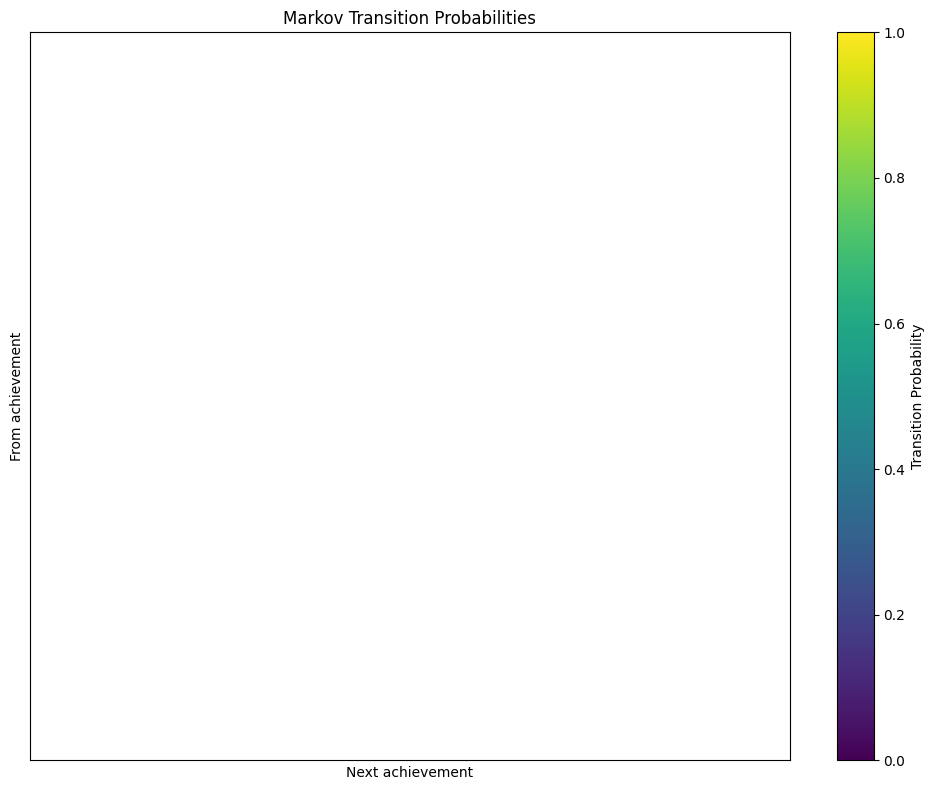

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 转概率矩阵
prob_mat = mk.trans_counts / mk.row_sums
prob_mat = np.array(prob_mat, dtype=float)  # 确保是 NumPy 数组

plt.figure(figsize=(10, 8))
im = plt.imshow(prob_mat, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Transition Probability')

plt.title("Markov Transition Probabilities")
plt.xlabel("Next achievement")
plt.ylabel("From achievement")

# 可选：加 tick labels（注意成就多的话不要全画）
xticks = list(mk.id2item.values())
yticks = list(mk.id2item.values())
plt.xticks(range(len(xticks)), xticks, rotation=90, fontsize=6)
plt.yticks(range(len(yticks)), yticks, fontsize=6)

plt.tight_layout()
plt.show()


In [26]:
print(events.head(10))  # 看 long 表的前 10 行
print("\n事件数：", events.shape[0])
print("成就种类数：", events['achievement'].nunique())

# 每个玩家的成就数分布
seq_lengths = events.groupby('player_id')['achievement'].nunique()
print("\n玩家成就数分布：")
print(seq_lengths.describe())
print(seq_lengths.value_counts().sort_index().head(20))


Empty DataFrame
Columns: [player_id, achievement, unlock_time_raw]
Index: []

事件数： 0
成就种类数： 0

玩家成就数分布：
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: achievement, dtype: float64
Series([], Name: count, dtype: int64)


In [28]:
# ==========================================================
# Wide → Events with robust fallback
# 1) 尝试用 *_unlocktime > 0 构建事件
# 2) 若仍为空，则用成就的 0/1 列 + *_global_unlock_rate 构建伪时间顺序
# ==========================================================

import re
import numpy as np
import pandas as pd

PLAYER_COL = "steamid"
UNLOCK_SUFFIX = "_unlocktime"
GLOBAL_RATE_SUFFIX = "_global_unlock_rate"
TREAT_ZERO_AS_LOCKED = True

def _long_from_unlocktime(df, player_col, unlock_suffix, treat_zero_as_locked):
    """优先使用 unlocktime 构建 events（可能返回空）"""
    unlock_cols = [c for c in df.columns if c.endswith(unlock_suffix)]
    if not unlock_cols:
        return pd.DataFrame(columns=["player_id","achievement","unlock_time_raw"]), []

    slim = df[[player_col] + unlock_cols].copy()
    long_df = slim.melt(id_vars=[player_col], var_name="ach_col", value_name="unlock_time_raw")
    long_df["achievement"] = long_df["ach_col"].str[:-len(unlock_suffix)]
    long_df["unlock_time_raw"] = pd.to_numeric(long_df["unlock_time_raw"], errors="coerce")

    long_df = long_df[~long_df["unlock_time_raw"].isna()]
    if treat_zero_as_locked:
        long_df = long_df[long_df["unlock_time_raw"] > 0]

    long_df = long_df.rename(columns={player_col: "player_id"})
    long_df = long_df[["player_id", "achievement", "unlock_time_raw"]].sort_values(
        ["player_id","unlock_time_raw","achievement"]
    )
    # 去相邻重复
    long_df["_prev_ach"] = long_df.groupby("player_id")["achievement"].shift(1)
    long_df["_prev_time"] = long_df.groupby("player_id")["unlock_time_raw"].shift(1)
    long_df = long_df[(long_df["achievement"] != long_df["_prev_ach"]) |
                      (long_df["unlock_time_raw"] != long_df["_prev_time"])]
    long_df = long_df.drop(columns=["_prev_ach","_prev_time"]).reset_index(drop=True)
    return long_df, unlock_cols

def build_events_with_fallback(df,
                               player_col=PLAYER_COL,
                               unlock_suffix=UNLOCK_SUFFIX,
                               global_rate_suffix=GLOBAL_RATE_SUFFIX,
                               treat_zero_as_locked=TREAT_ZERO_AS_LOCKED):
    # 1) 首选：unlocktime
    events, used_unlock_cols = _long_from_unlocktime(
        df, player_col, unlock_suffix, treat_zero_as_locked
    )
    if len(events) > 0:
        return events, used_unlock_cols, {"mode":"unlocktime"}

    # 2) 回退：0/1 列 + global unlock rate → 伪时间
    # 识别“基名”成就：同名存在 base 列（0/1）且存在 *_global_unlock_rate
    base_cols = set(df.columns)
    pattern = re.compile(rf"^(.*){re.escape(global_rate_suffix)}$")
    candidates = []
    for col in df.columns:
        m = pattern.match(col)
        if m:
            base = m.group(1)
            if base in base_cols:  # 有 0/1 列
                candidates.append(base)

    if not candidates:
        # 仍然不行，返回空框架
        return pd.DataFrame(columns=["player_id","achievement","unlock_time_raw"]), [], {"mode":"none"}

    keep_cols = [player_col] + candidates + [f"{a}{global_rate_suffix}" for a in candidates]
    slim = df[keep_cols].copy()

    # 将每行（玩家）中 value==1 的成就取出；用 global_rate 作为“越大越早”的伪时间（取负值排序）
    rows = []
    for _, row in slim.iterrows():
        pid = row[player_col]
        unlocked = []
        for a in candidates:
            val = row[a]
            if pd.notna(val):
                try:
                    if float(val) > 0:  # 认为已解锁
                        gr = row.get(f"{a}{global_rate_suffix}", np.nan)
                        gr = float(gr) if pd.notna(gr) else 0.0
                        # 伪时间 = -global_rate（越常见越靠前）；再加微小抖动以打破并列
                        pseudo_t = -gr + np.random.uniform(-1e-6, 1e-6)
                        unlocked.append((a, pseudo_t))
                except Exception:
                    pass
        if unlocked:
            unlocked.sort(key=lambda x: (x[1], x[0]))
            for a, t in unlocked:
                rows.append((pid, a, t))

    events_fb = pd.DataFrame(rows, columns=["player_id","achievement","unlock_time_raw"])
    if len(events_fb)==0:
        return events_fb, [], {"mode":"none"}

    # 去相邻重复
    events_fb = events_fb.sort_values(["player_id","unlock_time_raw","achievement"]).reset_index(drop=True)
    events_fb["_prev_ach"] = events_fb.groupby("player_id")["achievement"].shift(1)
    events_fb["_prev_time"] = events_fb.groupby("player_id")["unlock_time_raw"].shift(1)
    events_fb = events_fb[(events_fb["achievement"] != events_fb["_prev_ach"]) |
                          (events_fb["unlock_time_raw"] != events_fb["_prev_time"])].copy()
    events_fb = events_fb.drop(columns=["_prev_ach","_prev_time"]).reset_index(drop=True)

    return events_fb, [], {"mode":"fallback_global_rate"}


In [29]:
# 读取原始 CSV
df = pd.read_csv("7dtd_players.csv")

# 用增强版 wide→events
events, used_unlock_cols, info = build_events_with_fallback(df)
print("events mode:", info["mode"])
print("事件数：", len(events))
print("成就种类数：", events["achievement"].nunique())

# 后续与之前一致
seqs_df = (events.groupby("player_id")["achievement"].apply(list)
           .reset_index(name="sequence"))
seqs_df["seq_len"] = seqs_df["sequence"].apply(len)
seqs_df = seqs_df[seqs_df["seq_len"] >= 2].reset_index(drop=True)
sequences = seqs_df["sequence"].tolist()

print("玩家（序列≥2）数量：", len(seqs_df))

mk = MarkovNextItem(smoothing=1.0, min_count=1).fit(sequences)
X_last, y_next = leave_one_out_instances(sequences)
metrics = evaluate_markov(mk, X_last, y_next, ks=(1,3,5,10))
print(metrics)


events mode: fallback_global_rate
事件数： 41682
成就种类数： 43
玩家（序列≥2）数量： 1597
{'Hit@1': 0.04618764667698607, 'Hit@3': 0.12910071403605133, 'Hit@5': 0.20384980276626555, 'Hit@10': 0.36865231936885207, 'MRR': 0.14989172811098778}


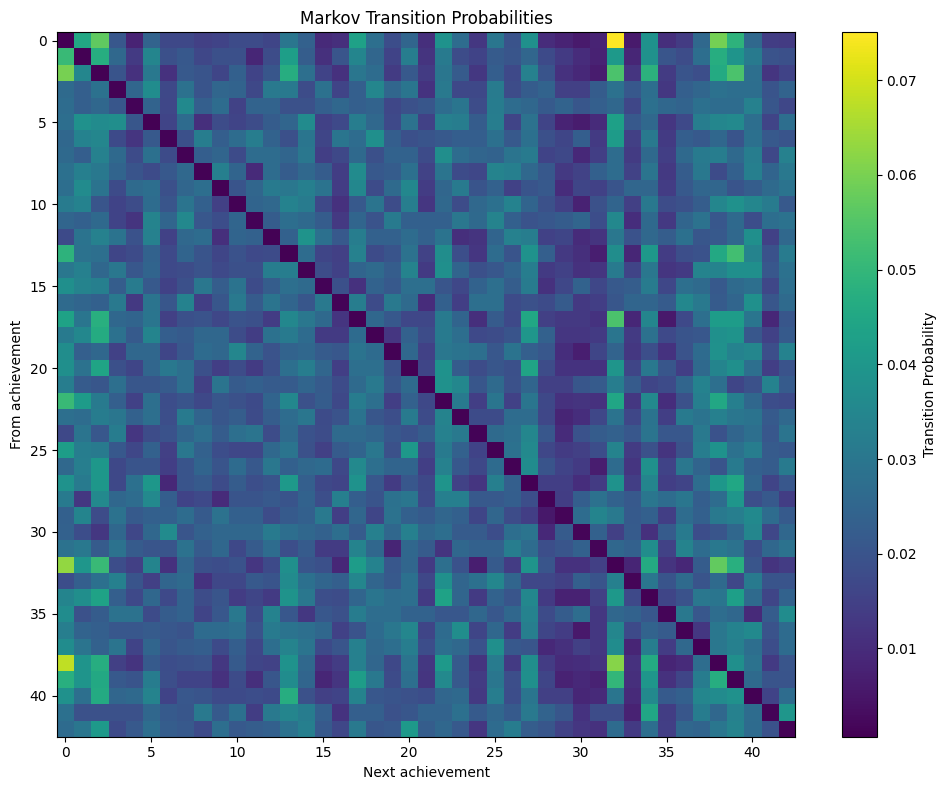

In [30]:
import matplotlib.pyplot as plt
import numpy as np

prob_mat = mk.trans_counts / mk.row_sums
prob_mat = np.array(prob_mat, dtype=float)

plt.figure(figsize=(10,8))
im = plt.imshow(prob_mat, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Transition Probability')
plt.title("Markov Transition Probabilities")
plt.xlabel("Next achievement"); plt.ylabel("From achievement")
plt.tight_layout(); plt.show()


In [31]:
prob_mat = mk.trans_counts / mk.row_sums
n = prob_mat.shape[0]
top_pairs = []
for i in range(n):
    for j in range(n):
        if i != j:
            top_pairs.append((mk.id2item[i], mk.id2item[j], prob_mat[i, j]))
top_pairs = sorted(top_pairs, key=lambda x: -x[2])[:20]
pd.DataFrame(top_pairs, columns=["From", "To", "Prob"])


,From,To,Prob
0,Bedroll,StoneAxe,0.075051
1,WoodFrame,Bedroll,0.067975
2,StoneAxe,Bedroll,0.062849
3,WoodFrame,StoneAxe,0.061668
4,Die1,Bedroll,0.059744
5,Bedroll,WoodFrame,0.059500
6,StoneAxe,WoodFrame,0.057263
7,Bedroll,Die1,0.056795
8,Die1,StoneAxe,0.054054
9,Die1,Zombies10,0.054054


In [33]:
# ==========================================================
# 7DTD Next-Achievement — 2nd-Order Markov with Backoff (full script)
# ----------------------------------------------------------
# What you get:
#   - Robust wide→events builder (unlocktime → fallback to global_rate)
#   - 1st-order Markov baseline (already proven working on your data)
#   - 2nd-order Markov (trigram) with backoff/interpolation to 1st-order
#   - Simple grid search for λ (interpolation weights)
#   - Leave-One-Out evaluation: Hit@K (1/3/5/10), MRR
#   - Top (A,B)->C transitions dump
#
# Input   : /mnt/data/7dtd_players.csv
# Outputs : transition CSVs (optional, end of script)
# ==========================================================

import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# --------------------------
# Config
# --------------------------
INPUT_PATH = "7dtd_players.csv"
PLAYER_COL = "steamid"

UNLOCK_SUFFIX = "_unlocktime"
GLOBAL_RATE_SUFFIX = "_global_unlock_rate"
TREAT_ZERO_AS_LOCKED = True

# Smoothing & eval
LAPLACE = 1.0
MIN_COUNT = 1
TOPK_LIST = (1, 3, 5, 10)

# Interpolation weights to try for 2nd-order backoff:
# p(next|A,B) = λ2 * p2 + λ1 * p1 + λ0 * p0
#   p2: trigram (A,B→*)
#   p1: bigram  (B→*)
#   p0: popularity (global)
LAMBDA_GRID = [
    (0.70, 0.25, 0.05),
    (0.60, 0.35, 0.05),
    (0.50, 0.40, 0.10),
    (0.40, 0.50, 0.10),
    (0.35, 0.55, 0.10),
    (0.30, 0.60, 0.10),
]

# ==========================================================
# 1) Wide → Events (with fallback)
# ==========================================================
def _long_from_unlocktime(df, player_col, unlock_suffix, treat_zero_as_locked):
    unlock_cols = [c for c in df.columns if c.endswith(unlock_suffix)]
    if not unlock_cols:
        return pd.DataFrame(columns=["player_id","achievement","unlock_time_raw"]), []

    slim = df[[player_col] + unlock_cols].copy()
    long_df = slim.melt(id_vars=[player_col], var_name="ach_col", value_name="unlock_time_raw")
    long_df["achievement"] = long_df["ach_col"].str[:-len(unlock_suffix)]
    long_df["unlock_time_raw"] = pd.to_numeric(long_df["unlock_time_raw"], errors="coerce")

    long_df = long_df[~long_df["unlock_time_raw"].isna()]
    if treat_zero_as_locked:
        long_df = long_df[long_df["unlock_time_raw"] > 0]

    long_df = long_df.rename(columns={player_col: "player_id"})
    long_df = long_df[["player_id", "achievement", "unlock_time_raw"]].sort_values(
        ["player_id","unlock_time_raw","achievement"]
    )
    # 去相邻重复
    long_df["_prev_ach"] = long_df.groupby("player_id")["achievement"].shift(1)
    long_df["_prev_time"] = long_df.groupby("player_id")["unlock_time_raw"].shift(1)
    long_df = long_df[(long_df["achievement"] != long_df["_prev_ach"]) |
                      (long_df["unlock_time_raw"] != long_df["_prev_time"])]
    long_df = long_df.drop(columns=["_prev_ach","_prev_time"]).reset_index(drop=True)
    return long_df, unlock_cols

def build_events_with_fallback(df,
                               player_col=PLAYER_COL,
                               unlock_suffix=UNLOCK_SUFFIX,
                               global_rate_suffix=GLOBAL_RATE_SUFFIX,
                               treat_zero_as_locked=TREAT_ZERO_AS_LOCKED):
    # 优先：unlocktime
    events, used_unlock_cols = _long_from_unlocktime(
        df, player_col, unlock_suffix, treat_zero_as_locked
    )
    if len(events) > 0:
        return events, used_unlock_cols, {"mode":"unlocktime"}

    # 回退：0/1 + global rate → 伪时间
    base_cols = set(df.columns)
    pattern = re.compile(rf"^(.*){re.escape(global_rate_suffix)}$")
    candidates = []
    for col in df.columns:
        m = pattern.match(col)
        if m:
            base = m.group(1)
            if base in base_cols:
                candidates.append(base)
    if not candidates:
        return pd.DataFrame(columns=["player_id","achievement","unlock_time_raw"]), [], {"mode":"none"}

    keep_cols = [player_col] + candidates + [f"{a}{global_rate_suffix}" for a in candidates]
    slim = df[keep_cols].copy()

    rows = []
    # 用 -global_rate 作为伪时间（更常见→更早），加微扰打破并列
    for _, row in slim.iterrows():
        pid = row[player_col]
        unlocked = []
        for a in candidates:
            val = row[a]
            if pd.notna(val):
                try:
                    if float(val) > 0:
                        gr = row.get(f"{a}{global_rate_suffix}", 0.0)
                        gr = float(gr) if pd.notna(gr) else 0.0
                        pseudo_t = -gr + np.random.uniform(-1e-6, 1e-6)
                        unlocked.append((a, pseudo_t))
                except Exception:
                    pass
        if unlocked:
            unlocked.sort(key=lambda x: (x[1], x[0]))
            for a, t in unlocked:
                rows.append((pid, a, t))

    events_fb = pd.DataFrame(rows, columns=["player_id","achievement","unlock_time_raw"])
    events_fb = events_fb.sort_values(["player_id","unlock_time_raw","achievement"]).reset_index(drop=True)
    events_fb["_prev_ach"] = events_fb.groupby("player_id")["achievement"].shift(1)
    events_fb["_prev_time"] = events_fb.groupby("player_id")["unlock_time_raw"].shift(1)
    events_fb = events_fb[(events_fb["achievement"] != events_fb["_prev_ach"]) |
                          (events_fb["unlock_time_raw"] != events_fb["_prev_time"])].copy()
    events_fb = events_fb.drop(columns=["_prev_ach","_prev_time"]).reset_index(drop=True)

    return events_fb, [], {"mode":"fallback_global_rate"}

# ==========================================================
# 2) Sequence building
# ==========================================================
def sequences_from_events(events, min_len=2):
    seqs = (events.groupby("player_id")["achievement"]
            .apply(list).reset_index(name="sequence"))
    seqs["seq_len"] = seqs["sequence"].apply(len)
    seqs = seqs[seqs["seq_len"] >= min_len].reset_index(drop=True)
    return seqs

# ==========================================================
# 3) First-Order Markov
# ==========================================================
class Markov1:
    def __init__(self, smoothing=1.0, min_count=1):
        self.smoothing = smoothing
        self.min_count = min_count
        self.item2id = {}
        self.id2item = {}
        self.C1 = None      # bigram counts
        self.row_sums = None
        self.pop = None     # popularity P0

    def fit(self, sequences):
        items = sorted({x for seq in sequences for x in seq})
        self.item2id = {a:i for i,a in enumerate(items)}
        self.id2item = {i:a for a,i in self.item2id.items()}
        n = len(items)
        C = np.zeros((n, n), dtype=np.float64)
        pop = np.zeros(n, dtype=np.float64)

        for seq in sequences:
            for t in range(1, len(seq)):
                i = self.item2id[seq[t-1]]
                j = self.item2id[seq[t]]
                C[i,j] += 1.0
                pop[j] += 1.0
        if self.min_count > 1:
            C[C < self.min_count] = 0.0

        C += self.smoothing
        self.C1 = C
        self.row_sums = C.sum(axis=1, keepdims=True)
        # popularity prior (smoothed)
        pop = pop + self.smoothing
        self.pop = pop / pop.sum()
        return self

    def proba1(self, last_item):
        if last_item not in self.item2id:
            return self.pop.copy()
        i = self.item2id[last_item]
        probs = self.C1[i] / (self.row_sums[i][0] if self.row_sums[i][0] > 0 else 1.0)
        return probs

# ==========================================================
# 4) Second-Order Markov with Backoff / Interpolation
# ==========================================================
class Markov2Backoff:
    """
    p(next | A,B) = λ2 * p2 + λ1 * p1 + λ0 * p0
      p2 : trigram (A,B→*)
      p1 : bigram  (B→*)
      p0 : popularity
    """
    def __init__(self, vocab, lambda2=0.6, lambda1=0.35, lambda0=0.05, smoothing=1.0, min_count=1):
        self.lambda2 = lambda2
        self.lambda1 = lambda1
        self.lambda0 = lambda0
        self.smoothing = smoothing
        self.min_count = min_count

        self.item2id = {a:i for i,a in enumerate(sorted(vocab))}
        self.id2item = {i:a for a,i in self.item2id.items()}

        n = len(self.item2id)
        self.C1 = np.zeros((n, n), dtype=np.float64)      # bigram
        self.row1 = np.zeros((n, 1), dtype=np.float64)

        self.C2 = defaultdict(lambda: np.zeros(n, dtype=np.float64))  # key=(i,j) -> counts over k
        self.row2 = defaultdict(float)

        self.pop = np.zeros(n, dtype=np.float64)

    def fit(self, sequences):
        for seq in sequences:
            for t in range(1, len(seq)):
                i = self.item2id[seq[t-1]]
                j = self.item2id[seq[t]]
                self.C1[i,j] += 1.0
                self.row1[i,0] += 1.0
                self.pop[j] += 1.0
            for t in range(2, len(seq)):
                i = self.item2id[seq[t-2]]; j = self.item2id[seq[t-1]]; k = self.item2id[seq[t]]
                self.C2[(i,j)][k] += 1.0
                self.row2[(i,j)] += 1.0

        # smoothing bigram
        self.C1 += self.smoothing
        self.row1 = self.C1.sum(axis=1, keepdims=True)
        # popularity
        self.pop = (self.pop + self.smoothing) / (self.pop.sum() + self.smoothing * len(self.pop))
        return self

    def _p1(self, j):
        # p(* | j)  using bigram rows over previous item j as "from"
        # Need row by 'from' index; our bigram matrix uses C1[from,to]
        row = self.C1[j]  # shape (n,)
        denom = row.sum()
        if denom <= 0:
            return np.full_like(row, 1.0/len(row))
        return row / denom

    def _p2(self, i, j):
        # p(* | i,j)  if never seen, return uniform
        vec = self.C2.get((i,j), None)
        if vec is None or vec.sum() == 0:
            return None
        v = vec + self.smoothing
        return v / v.sum()

    def predict_proba(self, last_item, prev_item=None):
        n = len(self.item2id)
        p0 = self.pop
        if last_item not in self.item2id:
            # cold-start: popularity only
            return p0.copy()
        j = self.item2id[last_item]
        p1 = self._p1(j)

        # try trigram if prev_item is provided
        if prev_item is not None and prev_item in self.item2id:
            i = self.item2id[prev_item]
            p2 = self._p2(i, j)
        else:
            p2 = None

        if p2 is None:
            # backoff to λ1 p1 + λ0 p0 (renormalize λ’s proportionally)
            s = self.lambda1 + self.lambda0
            return (self.lambda1/s) * p1 + (self.lambda0/s) * p0
        else:
            return self.lambda2 * p2 + self.lambda1 * p1 + self.lambda0 * p0

# ==========================================================
# 5) Evaluation (Leave-One-Out over all prefixes)
# ==========================================================
def leave_one_out_instances_for_order2(sequences):
    """
    Build samples:
      - for t>=2 use (prev=seq[t-2], last=seq[t-1]) -> target=seq[t]
      - for t==1 fallback to only (last=seq[0]) -> target=seq[1]  (so order-1 still gets evaluated)
    """
    samples = []
    for seq in sequences:
        for t in range(1, len(seq)):
            last = seq[t-1]
            prev = seq[t-2] if t-2 >= 0 else None
            target = seq[t]
            samples.append((prev, last, target))
    return samples

def evaluate_model_prob(get_probs_fn, samples, item2id, ks=(1,3,5,10)):
    topk_hits = {k:0 for k in ks}
    mrr_sum = 0.0
    n = len(samples)

    for prev, last, target in samples:
        probs = get_probs_fn(last, prev)  # ndarray of shape (V,)
        order = np.argsort(-probs)
        if target in item2id:
            tid = item2id[target]
            # rank of target
            rank = int(np.where(order == tid)[0][0]) + 1
            mrr_sum += 1.0 / rank
            for k in ks:
                if rank <= k:
                    topk_hits[k] += 1

    metrics = {f"Hit@{k}": topk_hits[k]/max(1,n) for k in ks}
    metrics["MRR"] = mrr_sum / max(1,n)
    return metrics

# ==========================================================
# 6) Main
# ==========================================================
if __name__ == "__main__":
    # Load & build events/sequences
    raw = pd.read_csv(INPUT_PATH)
    events, used_unlock_cols, info = build_events_with_fallback(raw)
    seqs_df = sequences_from_events(events, min_len=2)
    sequences = seqs_df["sequence"].tolist()

    meta = {
        "events_mode": info["mode"],
        "players_total": int(raw[PLAYER_COL].nunique()),
        "players_with_seq2+": int(seqs_df.shape[0]),
        "events_after_filter": int(events.shape[0]),
        "unique_achievements": int(events["achievement"].nunique()),
    }
    print("=== Data summary ===")
    print(json.dumps(meta, indent=2, ensure_ascii=False))

    # ------------------ 1st-order baseline ------------------
    m1 = Markov1(smoothing=LAPLACE, min_count=MIN_COUNT).fit(sequences)
    # reuse earlier LOO protocol but only last item:
    samples1 = [(None, seq[t-1], seq[t]) for seq in sequences for t in range(1,len(seq))]
    metrics_m1 = evaluate_model_prob(
        get_probs_fn=lambda last, prev: m1.proba1(last),
        samples=samples1, item2id=m1.item2id, ks=TOPK_LIST
    )
    print("\n=== First-Order Markov ===")
    for k in TOPK_LIST: print(f"Hit@{k}: {metrics_m1[f'Hit@{k}']:.4f}")
    print(f"MRR: {metrics_m1['MRR']:.4f}")

    # ------------------ 2nd-order with backoff --------------
    vocab = set(m1.item2id.keys())
    samples2 = leave_one_out_instances_for_order2(sequences)

    best_metrics = None
    best_lmb = None
    for (l2, l1, l0) in LAMBDA_GRID:
        m2 = Markov2Backoff(vocab, lambda2=l2, lambda1=l1, lambda0=l0,
                            smoothing=LAPLACE, min_count=MIN_COUNT).fit(sequences)
        metrics = evaluate_model_prob(
            get_probs_fn=lambda last, prev: m2.predict_proba(last, prev),
            samples=samples2, item2id=m2.item2id, ks=TOPK_LIST
        )
        tag = f"(λ2,λ1,λ0)=({l2:.2f},{l1:.2f},{l0:.2f})"
        print(f"\n=== Second-Order Backoff {tag} ===")
        for k in TOPK_LIST: print(f"Hit@{k}: {metrics[f'Hit@{k}']:.4f}")
        print(f"MRR: {metrics['MRR']:.4f}")

        if (best_metrics is None) or (metrics["MRR"] > best_metrics["MRR"]):
            best_metrics, best_lmb = metrics, (l2,l1,l0)

    print("\n=== Best 2nd-Order (by MRR) ===")
    print(f"Best lambdas: λ2={best_lmb[0]:.2f}, λ1={best_lmb[1]:.2f}, λ0={best_lmb[2]:.2f}")
    for k in TOPK_LIST: print(f"Hit@{k}: {best_metrics[f'Hit@{k}']:.4f}")
    print(f"MRR: {best_metrics['MRR']:.4f}")

    # ------------------ Top (A,B)->C transitions ------------
    # Using pure trigram counts (without smoothing/interp) just for inspection:
    m2_inspect = Markov2Backoff(vocab, lambda2=1, lambda1=0, lambda0=0,
                                smoothing=0.0, min_count=MIN_COUNT).fit(sequences)
    rows = []
    for (i,j), vec in m2_inspect.C2.items():
        total = vec.sum()
        if total <= 0: continue
        probs = vec / total
        k = int(np.argmax(probs))
        rows.append((
            m2_inspect.id2item[i],
            m2_inspect.id2item[j],
            m2_inspect.id2item[k],
            float(np.max(probs))
        ))
    rows = sorted(rows, key=lambda x: -x[3])[:30]
    df_top_trigrams = pd.DataFrame(rows, columns=["From_A","From_B","To","Prob"])
    print("\nTop (A,B)->C transitions (top 30 by prob):")
    print(df_top_trigrams.head(30).to_string(index=False))

    # ------------------ Optional: save matrices --------------
    # 1st-order transition matrix
    try:
        mat1 = pd.DataFrame(m1.C1, columns=[m1.id2item[j] for j in range(len(m1.id2item))])
        mat1.insert(0, "FROM", [m1.id2item[i] for i in range(len(m1.id2item))])
        mat1.to_csv("markov1_transition_matrix.csv", index=False)
        pd.DataFrame({"id": list(m1.id2item.keys()),
                      "achievement": [m1.id2item[i] for i in m1.id2item]}).to_csv(
            "markov_item_id_map.csv", index=False
        )
        print("\nSaved: /mnt/data/markov1_transition_matrix.csv, /mnt/data/markov_item_id_map.csv")
    except Exception as e:
        print("Skip saving matrices:", repr(e))


=== Data summary ===
{
  "events_mode": "fallback_global_rate",
  "players_total": 2306,
  "players_with_seq2+": 1597,
  "events_after_filter": 41682,
  "unique_achievements": 43
}

=== First-Order Markov ===
Hit@1: 0.0471
Hit@3: 0.1291
Hit@5: 0.2030
Hit@10: 0.3685
MRR: 0.1504

=== Second-Order Backoff (λ2,λ1,λ0)=(0.70,0.25,0.05) ===
Hit@1: 0.1240
Hit@3: 0.3059
Hit@5: 0.4440
Hit@10: 0.7090
MRR: 0.2869

=== Second-Order Backoff (λ2,λ1,λ0)=(0.60,0.35,0.05) ===
Hit@1: 0.1225
Hit@3: 0.3025
Hit@5: 0.4386
Hit@10: 0.6994
MRR: 0.2838

=== Second-Order Backoff (λ2,λ1,λ0)=(0.50,0.40,0.10) ===
Hit@1: 0.1199
Hit@3: 0.2947
Hit@5: 0.4283
Hit@10: 0.6797
MRR: 0.2777

=== Second-Order Backoff (λ2,λ1,λ0)=(0.40,0.50,0.10) ===
Hit@1: 0.1139
Hit@3: 0.2783
Hit@5: 0.4051
Hit@10: 0.6357
MRR: 0.2645

=== Second-Order Backoff (λ2,λ1,λ0)=(0.35,0.55,0.10) ===
Hit@1: 0.1087
Hit@3: 0.2668
Hit@5: 0.3884
Hit@10: 0.6075
MRR: 0.2548

=== Second-Order Backoff (λ2,λ1,λ0)=(0.30,0.60,0.10) ===
Hit@1: 0.1025
Hit@3: 0.2533
H

In [34]:
# ==========================================================
# 新手 vs 老手 分层评估
# ==========================================================

def evaluate_by_player_group(events_df, lambda_best=(0.70, 0.25, 0.05)):
    # 计算每个玩家总成就数
    ach_count = events_df.groupby("player_id")["achievement"].nunique()
    newbie_ids = set(ach_count[ach_count <= 10].index)
    veteran_ids = set(ach_count[ach_count > 10].index)

    results = {}

    for label, pid_set in [("Newbie(<=10)", newbie_ids), ("Veteran(>10)", veteran_ids)]:
        subset_events = events_df[events_df["player_id"].isin(pid_set)]
        seqs_df = sequences_from_events(subset_events, min_len=2)
        sequences_grp = seqs_df["sequence"].tolist()

        if len(sequences_grp) == 0:
            results[label] = None
            continue

        # 1阶
        m1_grp = Markov1(smoothing=LAPLACE, min_count=MIN_COUNT).fit(sequences_grp)
        samples1_grp = [(None, seq[t-1], seq[t]) for seq in sequences_grp for t in range(1,len(seq))]
        metrics_m1_grp = evaluate_model_prob(
            get_probs_fn=lambda last, prev: m1_grp.proba1(last),
            samples=samples1_grp, item2id=m1_grp.item2id, ks=TOPK_LIST
        )

        # 2阶
        vocab_grp = set(m1_grp.item2id.keys())
        m2_grp = Markov2Backoff(vocab_grp,
                                lambda2=lambda_best[0],
                                lambda1=lambda_best[1],
                                lambda0=lambda_best[2],
                                smoothing=LAPLACE, min_count=MIN_COUNT).fit(sequences_grp)
        samples2_grp = leave_one_out_instances_for_order2(sequences_grp)
        metrics_m2_grp = evaluate_model_prob(
            get_probs_fn=lambda last, prev: m2_grp.predict_proba(last, prev),
            samples=samples2_grp, item2id=m2_grp.item2id, ks=TOPK_LIST
        )

        results[label] = {
            "n_players": len(pid_set),
            "n_sequences": len(sequences_grp),
            "1st_order": metrics_m1_grp,
            "2nd_order": metrics_m2_grp
        }

    return results


# ===== 运行分层评估 =====
group_results = evaluate_by_player_group(events, lambda_best=(0.70, 0.25, 0.05))

print("\n=== Grouped Evaluation (Best λ) ===")
for group, res in group_results.items():
    if res is None:
        print(f"{group}: No data")
        continue
    print(f"\n--- {group} ---")
    print(f"Players: {res['n_players']} | Sequences: {res['n_sequences']}")
    print("1st-order:")
    for k in TOPK_LIST:
        print(f"  Hit@{k}: {res['1st_order'][f'Hit@{k}']:.4f}")
    print(f"  MRR: {res['1st_order']['MRR']:.4f}")
    print("2nd-order:")
    for k in TOPK_LIST:
        print(f"  Hit@{k}: {res['2nd_order'][f'Hit@{k}']:.4f}")
    print(f"  MRR: {res['2nd_order']['MRR']:.4f}")
    # 提升
    mrr_gain = res['2nd_order']['MRR'] - res['1st_order']['MRR']
    print(f"MRR 提升: {mrr_gain:+.4f}")



=== Grouped Evaluation (Best λ) ===

--- Newbie(<=10) ---
Players: 420 | Sequences: 389
1st-order:
  Hit@1: 0.1943
  Hit@3: 0.4809
  Hit@5: 0.6634
  Hit@10: 0.9164
  MRR: 0.3987
2nd-order:
  Hit@1: 0.3223
  Hit@3: 0.6211
  Hit@5: 0.7828
  Hit@10: 0.9750
  MRR: 0.5163
MRR 提升: +0.1176

--- Veteran(>10) ---
Players: 1208 | Sequences: 1208
1st-order:
  Hit@1: 0.0419
  Hit@3: 0.1171
  Hit@5: 0.1869
  Hit@10: 0.3471
  MRR: 0.1415
2nd-order:
  Hit@1: 0.1222
  Hit@3: 0.3030
  Hit@5: 0.4410
  Hit@10: 0.7086
  MRR: 0.2850
MRR 提升: +0.1435


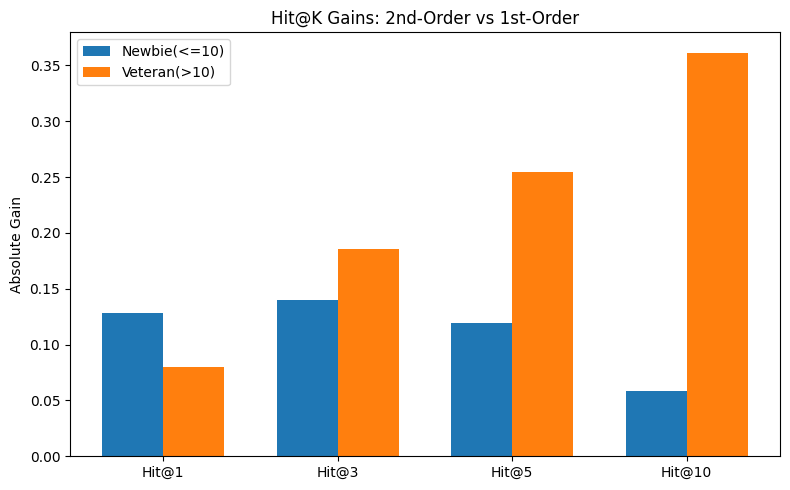

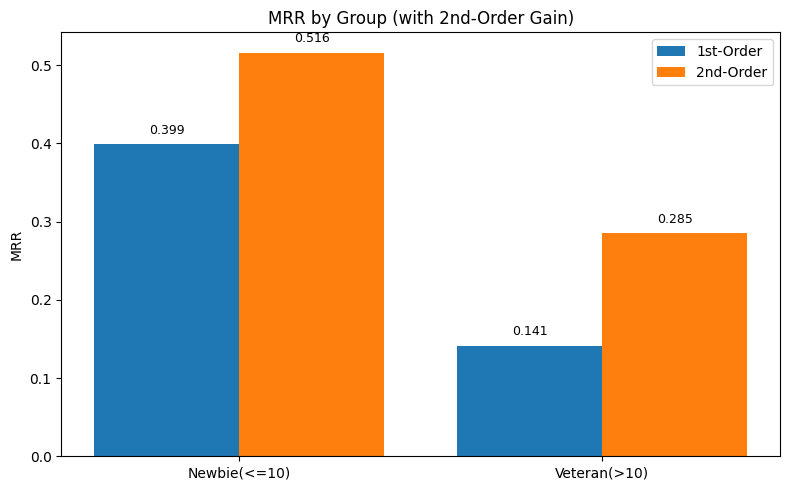

In [35]:
# ==============================
# Plot: Newbie vs Veteran gains
# ==============================
import matplotlib.pyplot as plt
import numpy as np

# Expect existing dict: group_results from previous step
# Structure:
# group_results = {
#   "Newbie(<=10)": {
#       "n_players": ...,
#       "n_sequences": ...,
#       "1st_order": {"Hit@1":..., "Hit@3":..., "Hit@5":..., "Hit@10":..., "MRR":...},
#       "2nd_order": {...}
#   },
#   "Veteran(>10)": {...}
# }

# ---- Prepare data ----
groups = ["Newbie(<=10)", "Veteran(>10)"]
ks = ["Hit@1", "Hit@3", "Hit@5", "Hit@10"]
mrr_key = "MRR"

def extract_metrics(grp):
    m1 = group_results[grp]["1st_order"]
    m2 = group_results[grp]["2nd_order"]
    gains = {k: (m2[k] - m1[k]) for k in ks + [mrr_key]}
    return m1, m2, gains

m1_new, m2_new, gains_new = extract_metrics(groups[0])
m1_vet, m2_vet, gains_vet = extract_metrics(groups[1])

# ---- Plot 1: Hit@K gains ----
x = np.arange(len(ks))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [gains_new[k] for k in ks], width, label='Newbie(<=10)')
plt.bar(x + width/2, [gains_vet[k] for k in ks], width, label='Veteran(>10)')
plt.xticks(x, ks)
plt.ylabel('Absolute Gain')
plt.title('Hit@K Gains: 2nd-Order vs 1st-Order')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: MRR levels & gain ----
plt.figure(figsize=(8,5))
bar_x = np.array([0, 1])  # Newbie, Veteran
plt.bar(bar_x - 0.2, [m1_new[mrr_key], m1_vet[mrr_key]], width=0.4, label='1st-Order')
plt.bar(bar_x + 0.2, [m2_new[mrr_key], m2_vet[mrr_key]], width=0.4, label='2nd-Order')
for i, (a,b) in enumerate(zip([m1_new[mrr_key], m1_vet[mrr_key]], [m2_new[mrr_key], m2_vet[mrr_key]])):
    plt.text(i - 0.2, a + 0.01, f"{a:.3f}", ha='center', va='bottom', fontsize=9)
    plt.text(i + 0.2, b + 0.01, f"{b:.3f}", ha='center', va='bottom', fontsize=9)
plt.xticks(bar_x, groups)
plt.ylabel('MRR')
plt.title('MRR by Group (with 2nd-Order Gain)')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# ===============================================
# Step 1 (WIDE + *_unlocktime 版) —— 读取与序列构建
#  - 自动识别所有 *_unlocktime 列
#  - 解析时间（兼容字符串/秒/毫秒时间戳）
#  - 对每位玩家按解锁时间排序，生成成就序列（token & id）
#  - 过滤过短序列（默认 <3）
# ===============================================

import re
from collections import OrderedDict, defaultdict
from typing import Dict, List, Optional

import numpy as np
import pandas as pd

# ==== 配置 ====
CSV_PATH = "7dtd_players.csv"
MIN_SEQ_LEN = 3
PLAYER_ID_CANDIDATES = ["steamid", "player_id", "userid", "user_id", "id"]

# ==== 工具 ====
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(r"[ \-\/]+", "_", regex=True)
    )
    return df

def find_first_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = set(df.columns)
    for c in candidates:
        if c in cols:
            return c
    return None

def parse_time_scalar(x):
    """
    尝试解析单个时间值：
    - 字符串时间: 交给 pandas 解析
    - 数值时间: 自动判断是秒(10位)还是毫秒(13位)级时间戳
    解析失败返回 NaT
    """
    if pd.isna(x):
        return pd.NaT
    # 数值：判断位数
    if isinstance(x, (int, float, np.integer, np.floating)):
        val = float(x)
        if np.isnan(val):
            return pd.NaT
        # 常见时间戳区间判断（粗略）：>1e12 可能是毫秒；>1e9 可能是秒
        if 1e12 <= val < 1e14:        # 毫秒级
            return pd.to_datetime(int(val), unit="ms", utc=True, errors="coerce")
        elif 1e9 <= val < 1e11:       # 秒级
            return pd.to_datetime(int(val), unit="s", utc=True, errors="coerce")
        else:
            # 直接尝试（有些数据是excel序列或其他基准）
            return pd.to_datetime(x, utc=True, errors="coerce", infer_datetime_format=True)
    # 其他（字符串等）
    return pd.to_datetime(x, utc=True, errors="coerce", infer_datetime_format=True)

class AchvEncoder:
    def __init__(self):
        self.achv2id: Dict[str, int] = OrderedDict()
        self.id2achv: List[str] = []

    def fit(self, sequences: List[List[str]]):
        for seq in sequences:
            for token in seq:
                if token not in self.achv2id:
                    self.achv2id[token] = len(self.achv2id)
                    self.id2achv.append(token)
        return self

    def transform(self, sequences: List[List[str]]) -> List[List[int]]:
        return [[self.achv2id[t] for t in seq if t in self.achv2id] for seq in sequences]

    def fit_transform(self, sequences: List[List[str]]) -> List[List[int]]:
        self.fit(sequences)
        return self.transform(sequences)

# ==== 序列构建（WIDE + *_unlocktime） ====
def build_sequences_from_wide_unlockcols(df: pd.DataFrame, player_col: str) -> Dict[str, List[str]]:
    """
    从拥有多列 *_unlocktime 的表构建序列：
      - 识别所有以 _unlocktime 结尾的列
      - 提取成就名 base = 列名去掉 _unlocktime
      - 对每位玩家：收集 (base, time)，剔除 NaT，按时间排序
      - 同一成就只保留首次时间
    返回：Dict[player_id] -> [token, token, ...]
    """
    unlock_cols = [c for c in df.columns if c.endswith("_unlocktime")]
    if not unlock_cols:
        raise ValueError("未找到任何 *_unlocktime 列，无法构建序列。")

    # 计算每个 *_unlocktime 实际可解析的时间（新建一个临时 DataFrame）
    time_df = pd.DataFrame(index=df.index)
    base_names = []
    for c in unlock_cols:
        base = c[:-11]  # 去掉 "_unlocktime"
        base_names.append(base)
        time_df[base] = df[c].map(parse_time_scalar)

    # 对每位玩家，将非 NaT 的成就按时间排序生成序列
    seqs = {}
    for i, row in time_df.iterrows():
        pid = str(df.loc[i, player_col])
        # (achv, timestamp) 列表
        pairs = [(achv, row[achv]) for achv in base_names if pd.notna(row[achv])]
        if not pairs:
            continue
        # 按时间排序
        pairs.sort(key=lambda x: x[1])
        # 保序+去重（同一成就只取最早）
        seen = set()
        ordered_tokens = []
        for achv, _t in pairs:
            if achv not in seen:
                ordered_tokens.append(achv)
                seen.add(achv)
        seqs[pid] = ordered_tokens
    return seqs

def filter_short_sequences(seqs: Dict[str, List[str]], min_len: int) -> Dict[str, List[str]]:
    return {k: v for k, v in seqs.items() if len(v) >= min_len}

def summarize_sequences(seqs_tokens: Dict[str, List[str]], enc: AchvEncoder) -> None:
    lengths = [len(v) for v in seqs_tokens.values()]
    n_players = len(seqs_tokens)
    uniq_achvs = len(enc.achv2id)

    print("===== 序列摘要 =====")
    print(f"玩家数：{n_players}")
    if lengths:
        print(f"序列长度：min={np.min(lengths)}, p25={np.percentile(lengths,25):.0f}, "
              f"median={np.median(lengths):.0f}, p75={np.percentile(lengths,75):.0f}, max={np.max(lengths)}")
    print(f"唯一成就数：{uniq_achvs}")

    # 映射示例
    print("\n前10个成就映射（token -> id）:")
    for i, (tok, idx) in enumerate(enc.achv2id.items()):
        if i >= 10:
            break
        print(f"  {tok} -> {idx}")

    # 样例玩家
    example_keys = list(seqs_tokens.keys())[:3]
    if example_keys:
        print("\n样例玩家序列（前3个）：")
        for k in example_keys:
            tok_seq = seqs_tokens[k]
            id_seq = [enc.achv2id[t] for t in tok_seq]
            print(f"- Player {k}:")
            print(f"  tokens: {tok_seq}")
            print(f"  ids   : {id_seq}")

# ==== 执行 ====
df_raw = pd.read_csv(CSV_PATH, low_memory=False)
df = normalize_columns(df_raw)

player_col = find_first_col(df, PLAYER_ID_CANDIDATES)
if not player_col:
    raise ValueError("未找到玩家ID列（例如 steamid）。")

# 构建序列
seqs_tokens = build_sequences_from_wide_unlockcols(df, player_col)

# 过滤过短
before_n = len(seqs_tokens)
seqs_tokens = filter_short_sequences(seqs_tokens, MIN_SEQ_LEN)
after_n = len(seqs_tokens)
print(f"过滤长度 < {MIN_SEQ_LEN} 的玩家：{before_n - after_n} 个被移除（剩余 {after_n} 个玩家）")

# 编码
encoder = AchvEncoder()
seqs_ids = encoder.fit_transform(list(seqs_tokens.values()))
player_ids = list(seqs_tokens.keys())
player2ids = {pid: seq for pid, seq in zip(player_ids, seqs_ids)}

# 摘要
summarize_sequences(seqs_tokens, encoder)

# 后续步骤提示
print("\n下一步：我们可以基于 player2ids 计算序列距离（编辑距离 / DTW / n-gram Jaccard），然后做聚类。")


/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_43022/744826597.py:61: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(x, utc=True, errors="coerce", infer_datetime_format=True)
/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_43022/744826597.py:61: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(x, utc=True, errors="coerce", infer_datetime_format=True)
/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_43022/744826597.py:61: UserWarning: The argument 'infer_datetime_format' is deprecated 

过滤长度 < 3 的玩家：65 个被移除（剩余 1563 个玩家）
===== 序列摘要 =====
玩家数：1563
序列长度：min=3, p25=12, median=28, p75=43, max=43
唯一成就数：43

前10个成就映射（token -> id）:
  bedroll -> 0
  stoneaxe -> 1
  die1 -> 2
  bleedout -> 3
  woodframe -> 4
  landclaim -> 5
  items50 -> 6
  items500 -> 7
  items1500 -> 8
  items5000 -> 9

样例玩家序列（前3个）：
- Player 76561198037802252:
  tokens: ['bedroll', 'stoneaxe', 'die1']
  ids   : [0, 1, 2]
- Player 76561198833431225:
  tokens: ['stoneaxe', 'bedroll', 'die1', 'bleedout', 'woodframe', 'landclaim', 'items50', 'items500', 'items1500', 'items5000', 'zombies10', 'zombies100', 'zombies500', 'zombies2500', 'players1', 'players5', 'players10', 'players25', 'travel10', 'travel50', 'travel250', 'travel1000', 'die7', 'die14', 'die28', 'fortitude4', 'fortitude6', 'fortitude8', 'fortitude10', 'level7', 'level28', 'level70', 'level140', 'level300', 'height255', 'height0', 'subzeronaked', 'kills44mag', 'legbreak', 'life60minute', 'life180minute', 'life600minute', 'life1680minute']
  ids   : [1

距离矩阵形状: (1563, 1563)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29609 (\N{CJK UNIFIED IDEOGRAPH-73A9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Framewo

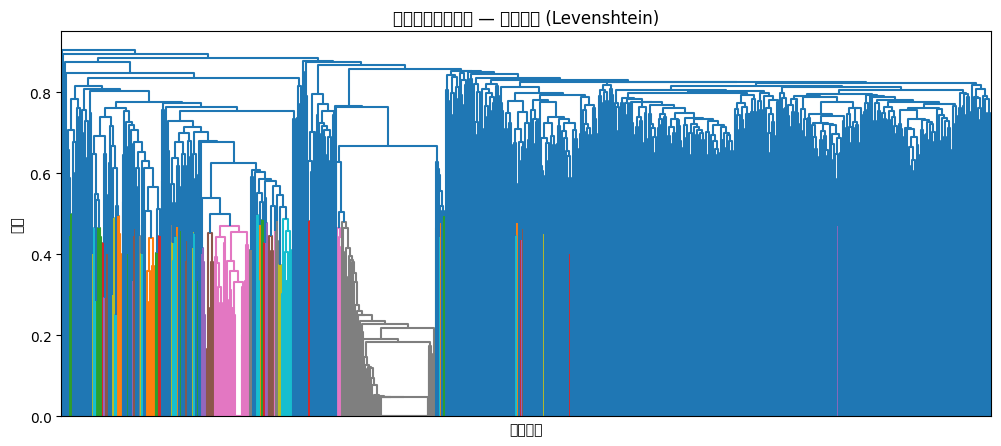

总簇数: 1059
簇大小分布:
  Cluster 110: 10 players
  Cluster 189: 157 players
  Cluster 502: 1 players
  Cluster 387: 3 players
  Cluster 680: 1 players
  Cluster 715: 1 players
  Cluster 721: 1 players
  Cluster 543: 1 players
  Cluster 729: 1 players
  Cluster 809: 1 players
  Cluster 212: 2 players
  Cluster 297: 2 players
  Cluster 1040: 1 players
  Cluster 658: 1 players
  Cluster 436: 1 players
  Cluster 823: 1 players
  Cluster 488: 1 players
  Cluster 1046: 1 players
  Cluster 690: 1 players
  Cluster 209: 2 players
  Cluster 613: 1 players
  Cluster 261: 1 players
  Cluster 311: 1 players
  Cluster 626: 1 players
  Cluster 350: 2 players
  Cluster 180: 1 players
  Cluster 499: 1 players
  Cluster 645: 1 players
  Cluster 575: 1 players
  Cluster 399: 1 players
  Cluster 443: 1 players
  Cluster 475: 1 players
  Cluster 3: 1 players
  Cluster 579: 1 players
  Cluster 188: 9 players
  Cluster 112: 59 players
  Cluster 126: 18 players
  Cluster 997: 1 players
  Cluster 853: 1 players
  C

In [5]:
# ===============================================
# Step 2 — 编辑距离相似度 + 层次聚类
# ===============================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import Levenshtein

# --- 1) 计算距离矩阵 ---
player_list = list(player2ids.keys())
n_players = len(player_list)
dist_matrix = np.zeros((n_players, n_players), dtype=float)

for i in range(n_players):
    seq_i = player2ids[player_list[i]]
    for j in range(i+1, n_players):
        seq_j = player2ids[player_list[j]]
        # Levenshtein 距离（整数）
        lev = Levenshtein.distance(seq_i, seq_j)
        # 归一化：除以两者最大长度，得到 0~1 范围
        norm_lev = lev / max(len(seq_i), len(seq_j))
        dist_matrix[i, j] = norm_lev
        dist_matrix[j, i] = norm_lev

print(f"距离矩阵形状: {dist_matrix.shape}")

# --- 2) 转换为 condensed form 并聚类 ---
condensed = squareform(dist_matrix)
Z = linkage(condensed, method="average")  # average linkage 更稳

# --- 3) 绘制树状图 ---
plt.figure(figsize=(12, 5))
dendrogram(Z, no_labels=True, color_threshold=0.5)
plt.title("玩家成就解锁顺序 — 层次聚类 (Levenshtein)")
plt.xlabel("玩家索引")
plt.ylabel("距离")
plt.show()

# --- 4) 设定阈值分簇 ---
THRESHOLD = 0.5  # 你可以调节这个阈值
labels = fcluster(Z, t=THRESHOLD, criterion="distance")

# --- 5) 输出簇大小分布 ---
from collections import Counter
cluster_counts = Counter(labels)
print(f"总簇数: {len(cluster_counts)}")
print("簇大小分布:")
for cid, count in cluster_counts.items():
    print(f"  Cluster {cid}: {count} players")

# --- 6) 把标签合并回玩家列表 ---
player_cluster_df = pd.DataFrame({
    "player_id": player_list,
    "cluster": labels
})

# 查看前 10 个
print(player_cluster_df.head(10))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31751 (\N{CJK UNIFIED IDEOGRAPH-7C07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Framewo

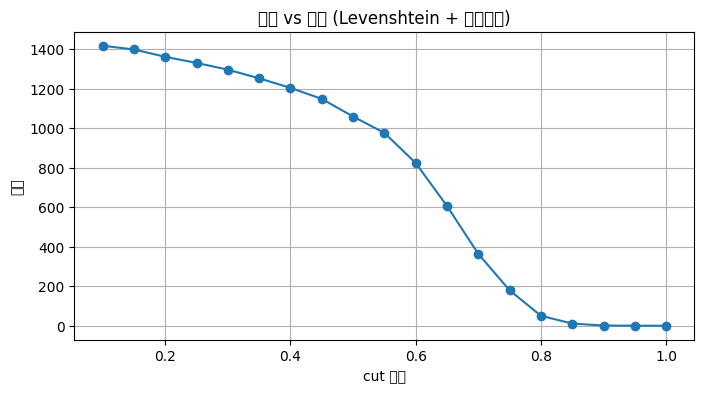

阈值=0.10 → 簇数=1417
阈值=0.15 → 簇数=1398
阈值=0.20 → 簇数=1361
阈值=0.25 → 簇数=1330
阈值=0.30 → 簇数=1296
阈值=0.35 → 簇数=1252
阈值=0.40 → 簇数=1204
阈值=0.45 → 簇数=1148
阈值=0.50 → 簇数=1059
阈值=0.55 → 簇数=976
阈值=0.60 → 簇数=824
阈值=0.65 → 簇数=606
阈值=0.70 → 簇数=364
阈值=0.75 → 簇数=180
阈值=0.80 → 簇数=51
阈值=0.85 → 簇数=12
阈值=0.90 → 簇数=2
阈值=0.95 → 簇数=1
阈值=1.00 → 簇数=1


In [6]:
# ===============================================
# Step 2.1 — 簇数 vs 阈值曲线
# ===============================================
import numpy as np
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

# 选择一组阈值范围（你可以调节步长，比如 0.05）
thresholds = np.arange(0.1, 1.01, 0.05)
cluster_counts = []

for t in thresholds:
    labels_t = fcluster(Z, t=t, criterion="distance")
    cluster_counts.append(len(set(labels_t)))

# 绘图
plt.figure(figsize=(8, 4))
plt.plot(thresholds, cluster_counts, marker="o")
plt.title("簇数 vs 阈值 (Levenshtein + 层次聚类)")
plt.xlabel("cut 阈值")
plt.ylabel("簇数")
plt.grid(True)
plt.show()

# 同时打印出每个阈值下的簇数
for t, c in zip(thresholds, cluster_counts):
    print(f"阈值={t:.2f} → 簇数={c}")


In [8]:
# ===============================================
# Step 3 — 代表序列 & 玩法风格分析
# ===============================================
from collections import defaultdict, Counter

# --- 1) Cut dendrogram 得到簇标签 ---
THRESHOLD = 0.65
labels = fcluster(Z, t=THRESHOLD, criterion="distance")
player_cluster_df = pd.DataFrame({
    "player_id": player_list,
    "cluster": labels
})

print(f"t={THRESHOLD} 时总簇数: {len(set(labels))}")
print("簇大小Top 10:")
print(player_cluster_df["cluster"].value_counts().head(10))

# --- 2) 成就类别映射（示例，可以按需要调整） ---
# 你可以根据自己的成就分类表来调整
combat_achvs = {"bleedout","zombies10","zombies100","zombies500","zombies2500","kills44mag"}
explore_achvs = {"travel10","travel50","travel250","travel1000","height255","height0","subzeronaked"}
craft_achvs = {"stoneaxe","bedroll","woodframe","landclaim","items50","items500","items1500","items5000"}

def get_category(achv):
    if achv in combat_achvs:
        return "combat"
    elif achv in explore_achvs:
        return "explore"
    elif achv in craft_achvs:
        return "craft"
    else:
        return "other"

# --- 3) 找中心玩家 ---
def find_cluster_center(player_ids_in_cluster):
    """返回中心玩家ID（到簇内其他玩家的平均编辑距离最小）"""
    best_pid = None
    best_avg_dist = float("inf")
    for pid in player_ids_in_cluster:
        seq_i = player2ids[pid]
        # 计算到簇内其他玩家的平均距离
        total_dist = 0
        count = 0
        for other_pid in player_ids_in_cluster:
            if pid == other_pid:
                continue
            seq_j = player2ids[other_pid]
            lev = Levenshtein.distance(seq_i, seq_j)
            norm_lev = lev / max(len(seq_i), len(seq_j))
            total_dist += norm_lev
            count += 1
        avg_dist = total_dist / count if count > 0 else 0
        if avg_dist < best_avg_dist:
            best_avg_dist = avg_dist
            best_pid = pid
    return best_pid, best_avg_dist

# --- 4) 输出前5个簇的代表序列 & 类别比例 ---
top_clusters = player_cluster_df["cluster"].value_counts().head(5).index

for cid in top_clusters:
    members = player_cluster_df[player_cluster_df["cluster"] == cid]["player_id"].tolist()
    center_pid, avg_dist = find_cluster_center(members)
    center_seq_tokens = [encoder.id2achv[i] for i in player2ids[center_pid]]
    
    # 类别统计
    categories = [get_category(a) for a in center_seq_tokens]
    cat_counts = Counter(categories)
    cat_ratio = {k: round(v / len(categories), 2) for k, v in cat_counts.items()}
    
    print(f"\n=== Cluster {cid} ===")
    print(f"成员数: {len(members)}")
    print(f"中心玩家: {center_pid} (平均簇内距离: {avg_dist:.3f})")
    print(f"代表序列: {center_seq_tokens}")
    print(f"类别比例: {cat_ratio}")


t=0.65 时总簇数: 606
簇大小Top 10:
cluster
84    167
48    154
34     34
21     19
41     19
25     17
85     17
65     11
42     10
45     10
Name: count, dtype: int64

=== Cluster 84 ===
成员数: 167
中心玩家: 76561198833431225 (平均簇内距离: 0.133)
代表序列: ['stoneaxe', 'bedroll', 'die1', 'bleedout', 'woodframe', 'landclaim', 'items50', 'items500', 'items1500', 'items5000', 'zombies10', 'zombies100', 'zombies500', 'zombies2500', 'players1', 'players5', 'players10', 'players25', 'travel10', 'travel50', 'travel250', 'travel1000', 'die7', 'die14', 'die28', 'fortitude4', 'fortitude6', 'fortitude8', 'fortitude10', 'level7', 'level28', 'level70', 'level140', 'level300', 'height255', 'height0', 'subzeronaked', 'kills44mag', 'legbreak', 'life60minute', 'life180minute', 'life600minute', 'life1680minute']
类别比例: {'craft': 0.19, 'other': 0.51, 'combat': 0.14, 'explore': 0.16}

=== Cluster 48 ===
成员数: 154
中心玩家: 76561198000000375 (平均簇内距离: 0.438)
代表序列: ['bedroll', 'stoneaxe', 'woodframe', 'die1']
类别比例: {'craft': 0.75, 'o

In [9]:
# ===============================================
# Step 3 (重跑版) — t=0.8 代表序列分析
# ===============================================

THRESHOLD = 0.8
labels_08 = fcluster(Z, t=THRESHOLD, criterion="distance")
player_cluster_df_08 = pd.DataFrame({
    "player_id": player_list,
    "cluster": labels_08
})

print(f"t={THRESHOLD} 时总簇数: {len(set(labels_08))}")
print("簇大小Top 10:")
print(player_cluster_df_08["cluster"].value_counts().head(10))

# 找中心玩家
def find_cluster_center(player_ids_in_cluster):
    best_pid = None
    best_avg_dist = float("inf")
    for pid in player_ids_in_cluster:
        seq_i = player2ids[pid]
        total_dist = 0
        count = 0
        for other_pid in player_ids_in_cluster:
            if pid == other_pid:
                continue
            seq_j = player2ids[other_pid]
            lev = Levenshtein.distance(seq_i, seq_j)
            norm_lev = lev / max(len(seq_i), len(seq_j))
            total_dist += norm_lev
            count += 1
        avg_dist = total_dist / count if count > 0 else 0
        if avg_dist < best_avg_dist:
            best_avg_dist = avg_dist
            best_pid = pid
    return best_pid, best_avg_dist

# 输出前 5 大簇的代表序列
top_clusters = player_cluster_df_08["cluster"].value_counts().head(5).index
for cid in top_clusters:
    members = player_cluster_df_08[player_cluster_df_08["cluster"] == cid]["player_id"].tolist()
    center_pid, avg_dist = find_cluster_center(members)
    center_seq_tokens = [encoder.id2achv[i] for i in player2ids[center_pid]]
    
    categories = [get_category(a) for a in center_seq_tokens]
    cat_counts = Counter(categories)
    cat_ratio = {k: round(v / len(categories), 2) for k, v in cat_counts.items()}
    
    print(f"\n=== Cluster {cid} ===")
    print(f"成员数: {len(members)}")
    print(f"中心玩家: {center_pid} (平均簇内距离: {avg_dist:.3f})")
    print(f"代表序列: {center_seq_tokens}")
    print(f"类别比例: {cat_ratio}")


t=0.8 时总簇数: 51
簇大小Top 10:
cluster
9     344
46    287
43    229
17    186
37    159
16     47
44     38
6      25
47     22
33     21
Name: count, dtype: int64

=== Cluster 9 ===
成员数: 344
中心玩家: 76561198018813445 (平均簇内距离: 0.566)
代表序列: ['bedroll', 'stoneaxe', 'woodframe', 'zombies10', 'die1']
类别比例: {'craft': 0.6, 'combat': 0.2, 'other': 0.2}

=== Cluster 46 ===
成员数: 287
中心玩家: 76561198043607469 (平均簇内距离: 0.718)
代表序列: ['bedroll', 'stoneaxe', 'woodframe', 'bleedout', 'zombies10', 'life60minute', 'travel10', 'landclaim', 'items50', 'die1', 'zombies100', 'level7', 'fortitude4', 'life180minute', 'travel50', 'legbreak', 'zombies500', 'items500', 'level28', 'life600minute', 'fortitude6', 'fortitude8', 'fortitude10', 'travel250', 'die7', 'die14', 'level70', 'level140']
类别比例: {'craft': 0.21, 'combat': 0.14, 'other': 0.54, 'explore': 0.11}

=== Cluster 43 ===
成员数: 229
中心玩家: 76561198119067891 (平均簇内距离: 0.719)
代表序列: ['stoneaxe', 'woodframe', 'bedroll', 'items50', 'life60minute', 'zombies10', 'level7', 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31751 (\N{CJK UNIFIED IDEOGRAPH-7C07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Framewo

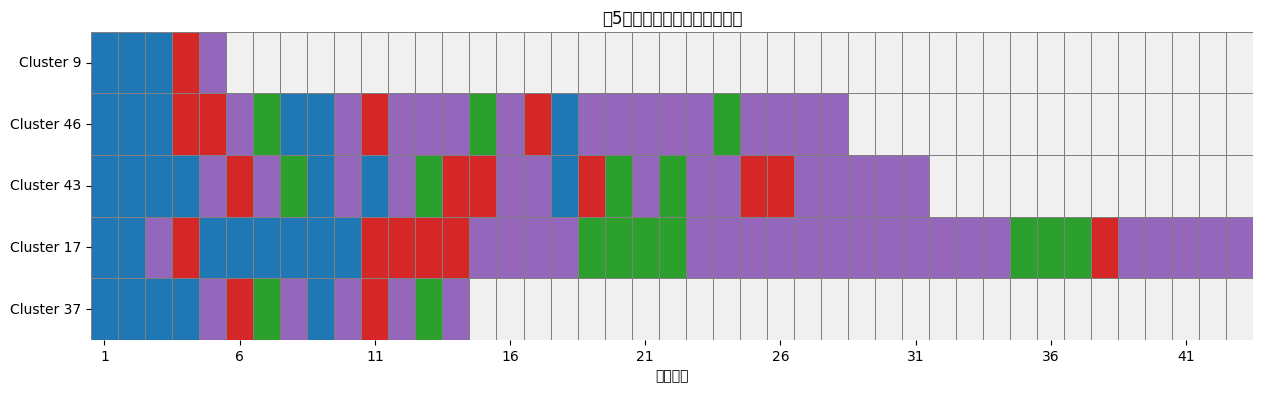

In [10]:
# ===============================================
# Step 4 — 簇代表序列类别热力图
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns

# 选取前5大簇
top_clusters = player_cluster_df_08["cluster"].value_counts().head(5).index
cluster_reps = []  # 每簇的类别序列
cluster_labels = []  # 簇ID

for cid in top_clusters:
    members = player_cluster_df_08[player_cluster_df_08["cluster"] == cid]["player_id"].tolist()
    center_pid, _ = find_cluster_center(members)
    center_seq_tokens = [encoder.id2achv[i] for i in player2ids[center_pid]]
    categories = [get_category(a) for a in center_seq_tokens]
    cluster_reps.append(categories)
    cluster_labels.append(f"Cluster {cid}")

# 找到最长代表序列长度（短的补空）
max_len = max(len(seq) for seq in cluster_reps)
cat_to_num = {"craft": 0, "combat": 1, "explore": 2, "other": 3, None: 4}
num_to_cat = {v: k for k, v in cat_to_num.items()}

# 转成数值矩阵，短序列补 None
matrix = []
for seq in cluster_reps:
    padded = seq + [None] * (max_len - len(seq))
    matrix.append([cat_to_num[c] for c in padded])

# 颜色映射
palette = {
    0: "#1f77b4",  # craft - 蓝
    1: "#d62728",  # combat - 红
    2: "#2ca02c",  # explore - 绿
    3: "#9467bd",  # other - 紫
    4: "#f0f0f0"   # None - 灰
}
cmap = sns.color_palette([palette[i] for i in sorted(palette.keys())])

# 绘制热力图
plt.figure(figsize=(15, 4))
sns.heatmap(matrix, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray')
plt.yticks(np.arange(len(cluster_labels)) + 0.5, cluster_labels, rotation=0)
plt.xticks(np.arange(0.5, max_len, 5), np.arange(1, max_len+1, 5))
plt.xlabel("序列位置")
plt.title("前5大簇的代表序列类别热力图")
plt.show()


In [14]:
# =========================================================
# Per-stratum hyperparameter search:
# - Sweep distance thresholds (0.10..1.00, step 0.05)
# - Sweep #clusters k (2..20) on the same linkage tree
# - Score with Silhouette (precomputed distances) and DB* (distance-based)
# - Pick best by Silhouette; break ties by lower DB*
# =========================================================
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def pairwise_distance_matrix(pids, p2ids):
    n = len(pids)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        si = p2ids[pids[i]]
        for j in range(i+1, n):
            sj = p2ids[pids[j]]
            d = Levenshtein.distance(si, sj) / max(len(si), len(sj))
            D[i, j] = D[j, i] = d
    return D

def has_valid_clusters(labels):
    if len(set(labels)) < 2:
        return False
    cnt = Counter(labels)
    return all(v >= 2 for v in cnt.values())

def cluster_medoids_and_scatter(D, labels):
    """Return medoid index per cluster and intra-cluster mean pairwise scatter S."""
    medoid_idx = {}
    scatter = {}
    for cid in sorted(set(labels)):
        idx = np.where(labels == cid)[0]
        if len(idx) < 2:
            # silhouette gate already avoids this; still guard.
            medoid_idx[cid] = idx[0]
            scatter[cid] = 0.0
            continue
        subD = D[np.ix_(idx, idx)]
        # medoid = row with min average distance
        avg_row = subD.sum(axis=1) / (len(idx) - 1)
        m_local = int(idx[np.argmin(avg_row)])
        medoid_idx[cid] = m_local
        # mean pairwise within-cluster distance
        iu = np.triu_indices(len(idx), k=1)
        scatter[cid] = float(subD[iu].mean()) if iu[0].size else 0.0
    return medoid_idx, scatter

def davies_bouldin_star(D, labels):
    """DB* computed from distances via medoids and mean intra distances."""
    labels = np.asarray(labels)
    medoid_idx, S = cluster_medoids_and_scatter(D, labels)
    cids = sorted(S.keys())
    if len(cids) < 2:
        return np.nan
    # distances between medoids
    M = {}
    for i, ci in enumerate(cids):
        for cj in cids[i+1:]:
            dij = float(D[medoid_idx[ci], medoid_idx[cj]])
            M[(ci, cj)] = M[(cj, ci)] = max(dij, 1e-12)  # avoid divide-by-zero
    # DB*
    Rmax = []
    for ci in cids:
        Rij = []
        for cj in cids:
            if ci == cj: 
                continue
            Rij.append((S[ci] + S[cj]) / M[(ci, cj)])
        Rmax.append(max(Rij))
    return float(np.mean(Rmax))

def evaluate_threshold_sweep(D, link_method="average",
                             thresholds=np.round(np.arange(0.10, 1.001, 0.05), 2)):
    Z = linkage(squareform(D), method=link_method)
    rows = []
    for t in thresholds:
        labels = fcluster(Z, t=t, criterion="distance")
        if not has_valid_clusters(labels):
            rows.append({"mode":"threshold","param":t,"k":len(set(labels)),
                        "silhouette":np.nan,"db_star":np.nan})
            continue
        sil = silhouette_score(D, labels, metric="precomputed")
        dbs = davies_bouldin_star(D, labels)
        rows.append({"mode":"threshold","param":t,"k":len(set(labels)),
                     "silhouette":sil, "db_star":dbs})
    return pd.DataFrame(rows), Z

def evaluate_k_sweep(D, Z, ks=range(2, 21)):
    rows = []
    for k in ks:
        labels = fcluster(Z, t=k, criterion="maxclust")
        if not has_valid_clusters(labels):
            rows.append({"mode":"k","param":k,"k":len(set(labels)),
                        "silhouette":np.nan,"db_star":np.nan})
            continue
        sil = silhouette_score(D, labels, metric="precomputed")
        dbs = davies_bouldin_star(D, labels)
        rows.append({"mode":"k","param":k,"k":len(set(labels)),
                     "silhouette":sil,"db_star":dbs})
    return pd.DataFrame(rows)

def pick_best(df):
    """Primary: max silhouette; tie-break: min DB*; final tie: fewer clusters."""
    df_valid = df.dropna(subset=["silhouette","db_star"]).copy()
    if df_valid.empty:
        return None
    # rank by -silhouette (desc), db_star (asc), k (asc)
    df_valid["rank_tuple"] = list(zip(-df_valid["silhouette"], df_valid["db_star"], df_valid["k"]))
    best_row = df_valid.sort_values("rank_tuple").iloc[0]
    return best_row

# Run per stratum
tuning_summary = {}
labels_best = {}

for stratum, pids in strata.items():
    print(f"\n=== Hyperparameter search for {stratum} (n={len(pids)}) ===")
    if len(pids) < 4:
        print("Too few players; skipping.")
        continue
    D = pairwise_distance_matrix(pids, player2ids)

    # threshold sweep
    df_thr, Z = evaluate_threshold_sweep(D, link_method="average")
    # k sweep on same Z
    df_k = evaluate_k_sweep(D, Z, ks=range(2, 21))

    df_all = pd.concat([df_thr, df_k], ignore_index=True)
    best = pick_best(df_all)

    print("Top candidates (by silhouette then DB*):")
    disp = df_all.sort_values(["silhouette"], ascending=False).head(8)
    print(disp.to_string(index=False, formatters={"silhouette":"{:.4f}".format,
                                                  "db_star":"{:.4f}".format}))

    if best is None:
        print("No valid clustering found (likely too many singletons).")
        continue

    print(f"\nSelected → mode={best.mode}, param={best.param}, "
          f"k={int(best.k)}, silhouette={best.silhouette:.4f}, DB*={best.db_star:.4f}")

    # get final labels for the chosen setting
    if best.mode == "threshold":
        labels = fcluster(Z, t=float(best.param), criterion="distance")
    else:
        labels = fcluster(Z, t=int(best.param), criterion="maxclust")

    labels_best[stratum] = pd.DataFrame({"player_id": pids, "cluster": labels})
    tuning_summary[stratum] = {"mode": best.mode, "param": float(best.param),
                               "k": int(best.k), "silhouette": float(best.silhouette),
                               "db_star": float(best.db_star)}

print("\n=== Best setting per stratum ===")
for s, info in tuning_summary.items():
    print(f"{s}: {info}")



=== Hyperparameter search for FULL (n=433) ===
Top candidates (by silhouette then DB*):
     mode  param  k silhouette db_star
        k    7.0  7     0.2756  1.7683
        k    8.0  8     0.2724  1.8616
        k    6.0  6     0.2674  1.7560
        k    2.0  2     0.1700  1.8834
        k    3.0  3     0.1541  1.8398
threshold    0.9  4     0.1395  1.8324
        k    4.0  4     0.1395  1.8324
        k    5.0  5     0.1323  1.8239

Selected → mode=<bound method Series.mode of mode                                                     k
param                                                  7.0
k                                                        7
silhouette                                        0.275644
db_star                                           1.768258
rank_tuple    (-0.2756441832478804, 1.7682583727129833, 7)
Name: 24, dtype: object>, param=7.0, k=7, silhouette=0.2756, DB*=1.7683

=== Hyperparameter search for EARLY (n=355) ===
Top candidates (by silhouette then DB*)

=== Auto-tuning per stratum with mixed strategies ===

[FULL] top candidates:
     mode  param  k silhouette db_star
        k    7.0  7     0.2756  1.7683
        k    8.0  8     0.2724  1.8616
        k    6.0  6     0.2674  1.7560
        k    2.0  2     0.1700  1.8834
        k    3.0  3     0.1541  1.8398
threshold    0.9  4     0.1395  1.8324
        k    4.0  4     0.1395  1.8324
        k    5.0  5     0.1323  1.8239
[FULL] Selected → mode=<bound method Series.mode of mode                                                     k
param                                                  7.0
k                                                        7
silhouette                                        0.275644
db_star                                           1.768258
rank_tuple    (-0.2756441832478804, 1.7682583727129833, 7)
Name: 24, dtype: object>, param=7.0, k=7, silhouette=0.2756, DB*=1.7683

[EARLY] top candidates:
     mode  param   k silhouette db_star
threshold   0.90   2     0.2

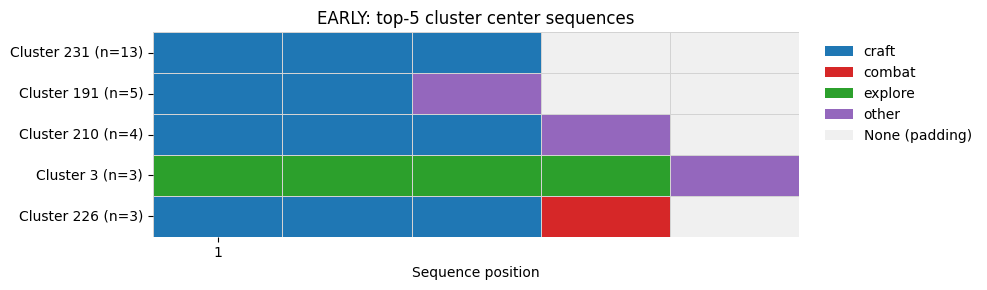

[MID] no clusters to show.


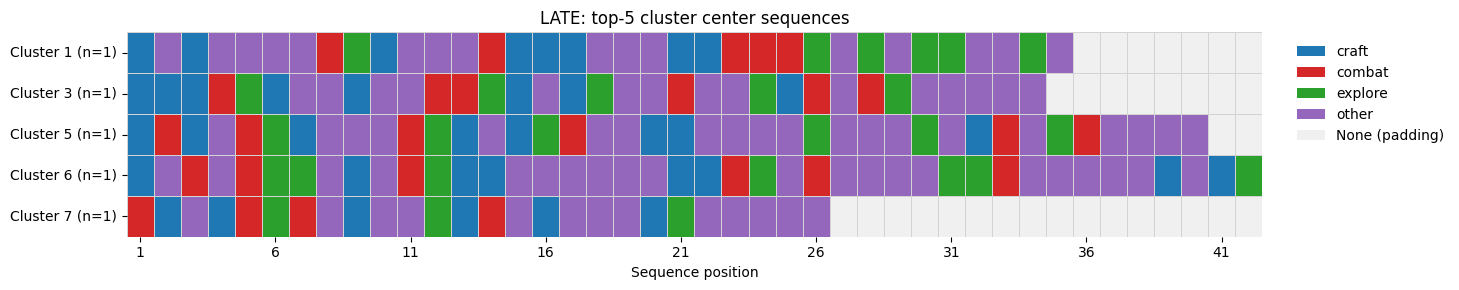

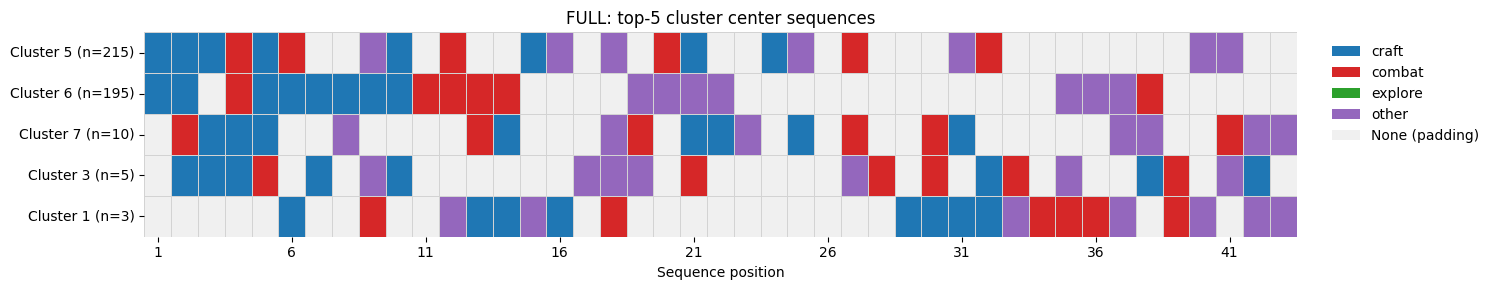

In [17]:
# ==============================================================
# MID/LATE: Category n-gram Jaccard (with optional positional decay)
# EARLY/FULL: Keep Levenshtein
#
# This cell:
#   - Builds category sequences per player
#   - MID & LATE: truncates to first N steps and compares with
#     (weighted) Jaccard over category n-grams
#   - EARLY & FULL: uses normalized Levenshtein
#   - Per stratum, runs hyperparameter search (threshold 0.10..1.00 step 0.05
#     and k = 2..20), selects best by Silhouette (tie-break by DB*)
#   - Produces final labels and cluster summaries
#   - Draws heatmaps for top-K clusters per stratum
#
# Prereqs from earlier steps:
#   - player2ids : Dict[player_id -> List[int]]  (achievement ID sequences)
#   - encoder    : has `id2achv` mapping IDs -> tokens
#   - get_category(token: str) -> {"craft","combat","explore","other"}
#   - strata     : {"EARLY":[...], "MID":[...], "LATE":[...], "FULL":[...]}
# ==============================================================

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from typing import Dict, List, Tuple
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein

# -----------------------------
# Helpers: category sequences
# -----------------------------
def seq_ids_to_tokens(seq_ids: List[int], encoder) -> List[str]:
    return [encoder.id2achv[i] for i in seq_ids]

def tokens_to_categories(tokens: List[str]) -> List[str]:
    return [get_category(t) for t in tokens]

def truncate(seq: List[str], max_len: int) -> List[str]:
    return seq[:max_len] if len(seq) > max_len else list(seq)

def cat_ngrams(seq_cats: List[str], n: int = 2) -> List[tuple]:
    if len(seq_cats) < n:
        return []
    return [tuple(seq_cats[i:i+n]) for i in range(len(seq_cats)-n+1)]

def weighted_jaccard_distance_from_ngrams(
    ngrams_a: List[tuple],
    ngrams_b: List[tuple],
    weights_a: List[float] = None,
    weights_b: List[float] = None
) -> float:
    """
    Weighted Jaccard distance for multisets via per-occurrence weights.
    If weights_* are None, each n-gram occurrence weight = 1.0.
    Distance = 1 - (sum over g min(wA[g], wB[g])) / (sum over g max(wA[g], wB[g]))
    """
    if weights_a is None:
        weights_a = [1.0] * len(ngrams_a)
    if weights_b is None:
        weights_b = [1.0] * len(ngrams_b)

    def to_weight_map(ngrams, weights):
        d = defaultdict(float)
        for g, w in zip(ngrams, weights):
            d[g] += float(w)
        return d

    A = to_weight_map(ngrams_a, weights_a)
    B = to_weight_map(ngrams_b, weights_b)
    if not A and not B:
        return 0.0
    keys = set(A) | set(B)
    inter = sum(min(A.get(k, 0.0), B.get(k, 0.0)) for k in keys)
    uni   = sum(max(A.get(k, 0.0), B.get(k, 0.0)) for k in keys)
    if uni <= 0:
        return 0.0
    return 1.0 - (inter / uni)

def decay_weights(length: int, n: int = 2, decay: float = 0.92) -> List[float]:
    """
    Positional decay weights for n-grams based on start position i:
      w_i = decay^i, i = 0..(length-n)
    Earlier steps get slightly higher weights (more important).
    """
    if length < n:
        return []
    return [decay**i for i in range(length - n + 1)]

# -----------------------------
# Distance matrices
# -----------------------------
def D_levenshtein(pids: List[str], p2ids: Dict[str, List[int]]) -> np.ndarray:
    n = len(pids)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        si = p2ids[pids[i]]
        for j in range(i+1, n):
            sj = p2ids[pids[j]]
            d = Levenshtein.distance(si, sj) / max(len(si), len(sj))
            D[i, j] = D[j, i] = d
    return D

def D_category_jaccard(
    pids: List[str],
    p2ids: Dict[str, List[int]],
    encoder,
    ngram_n: int = 2,
    max_len: int = 15,
    weighted: bool = True,
    decay: float = 0.92
) -> np.ndarray:
    """
    Category n-gram (weighted) Jaccard distance.
    Steps:
      - ID seq -> tokens -> categories
      - truncate to first `max_len`
      - extract n-grams
      - compute (weighted) Jaccard distance
    """
    cats = []
    ngrams = []
    weights = []
    for pid in pids:
        tok = seq_ids_to_tokens(p2ids[pid], encoder)
        cat = tokens_to_categories(tok)
        cat_trunc = truncate(cat, max_len=max_len)
        cats.append(cat_trunc)
        ng = cat_ngrams(cat_trunc, n=ngram_n)
        ngrams.append(ng)
        if weighted:
            weights.append(decay_weights(len(cat_trunc), n=ngram_n, decay=decay))
        else:
            weights.append([1.0] * len(ng))

    n = len(pids)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            dij = weighted_jaccard_distance_from_ngrams(
                ngrams[i], ngrams[j],
                weights_a=weights[i], weights_b=weights[j]
            )
            D[i, j] = D[j, i] = dij
    return D

# -----------------------------
# Clustering quality & selection
# -----------------------------
def has_valid_clusters(labels) -> bool:
    if len(set(labels)) < 2:
        return False
    cnt = Counter(labels)
    return all(v >= 2 for v in cnt.values())

def medoids_and_scatter_from_D(D: np.ndarray, labels: np.ndarray) -> Tuple[Dict[int,int], Dict[int,float]]:
    medoid_idx = {}
    scatter = {}
    for cid in sorted(set(labels)):
        idx = np.where(labels == cid)[0]
        if len(idx) < 2:
            medoid_idx[cid] = idx[0]
            scatter[cid] = 0.0
            continue
        subD = D[np.ix_(idx, idx)]
        avg_row = subD.sum(axis=1) / (len(idx) - 1)
        m_local_pos = int(np.argmin(avg_row))
        medoid_idx[cid] = int(idx[m_local_pos])
        iu = np.triu_indices(len(idx), k=1)
        scatter[cid] = float(subD[iu].mean()) if iu[0].size else 0.0
    return medoid_idx, scatter

def davies_bouldin_star_from_D(D: np.ndarray, labels: np.ndarray) -> float:
    labels = np.asarray(labels)
    medoid_idx, S = medoids_and_scatter_from_D(D, labels)
    cids = sorted(S.keys())
    if len(cids) < 2:
        return np.nan
    M = {}
    for i, ci in enumerate(cids):
        for cj in cids[i+1:]:
            dij = float(D[medoid_idx[ci], medoid_idx[cj]])
            M[(ci, cj)] = M[(cj, ci)] = max(dij, 1e-12)
    Rmax = []
    for ci in cids:
        Rij = []
        for cj in cids:
            if ci == cj:
                continue
            Rij.append((S[ci] + S[cj]) / M[(ci, cj)])
        Rmax.append(max(Rij))
    return float(np.mean(Rmax))

def evaluate_threshold_sweep_from_D(
    D: np.ndarray,
    link_method: str = "average",
    thresholds = np.round(np.arange(0.10, 1.001, 0.05), 2)
) -> Tuple[pd.DataFrame, np.ndarray]:
    Z = linkage(squareform(D), method=link_method)
    rows = []
    for t in thresholds:
        labels = fcluster(Z, t=float(t), criterion="distance")
        if not has_valid_clusters(labels):
            rows.append({"mode":"threshold","param":t,"k":len(set(labels)),"silhouette":np.nan,"db_star":np.nan})
            continue
        sil = silhouette_score(D, labels, metric="precomputed")
        dbs = davies_bouldin_star_from_D(D, labels)
        rows.append({"mode":"threshold","param":t,"k":len(set(labels)),"silhouette":sil,"db_star":dbs})
    return pd.DataFrame(rows), Z

def evaluate_k_sweep_from_Z(D: np.ndarray, Z: np.ndarray, ks=range(2, 21)) -> pd.DataFrame:
    rows = []
    for k in ks:
        labels = fcluster(Z, t=int(k), criterion="maxclust")
        if not has_valid_clusters(labels):
            rows.append({"mode":"k","param":k,"k":len(set(labels)),"silhouette":np.nan,"db_star":np.nan})
            continue
        sil = silhouette_score(D, labels, metric="precomputed")
        dbs = davies_bouldin_star_from_D(D, labels)
        rows.append({"mode":"k","param":k,"k":len(set(labels)),"silhouette":sil,"db_star":dbs})
    return pd.DataFrame(rows)

def pick_best(df: pd.DataFrame):
    df_valid = df.dropna(subset=["silhouette","db_star"]).copy()
    if df_valid.empty:
        return None
    df_valid["rank_tuple"] = list(zip(-df_valid["silhouette"], df_valid["db_star"], df_valid["k"]))
    return df_valid.sort_values("rank_tuple").iloc[0]

# -----------------------------
# Strategy per stratum
# -----------------------------
# EARLY & FULL: Levenshtein
# MID & LATE  : Category n-gram Jaccard (truncated, weighted)
strategy_map = {
    "EARLY": {"mode": "lev"},
    "FULL":  {"mode": "lev"},
    "MID":   {"mode": "cat", "ngram_n": 2, "max_len": 15, "weighted": True, "decay": 0.92},
    "LATE":  {"mode": "cat", "ngram_n": 2, "max_len": 15, "weighted": True, "decay": 0.92},
}

auto_labels = {}
auto_best = {}
auto_results = {}

print("=== Auto-tuning per stratum with mixed strategies ===")
for stratum, pids in strata.items():
    if len(pids) < 4:
        print(f"{stratum}: too few players, skipping.")
        continue

    cfg = strategy_map.get(stratum, {"mode": "lev"})
    if cfg["mode"] == "lev":
        D = D_levenshtein(pids, player2ids)
    else:
        D = D_category_jaccard(
            pids, player2ids, encoder,
            ngram_n=cfg.get("ngram_n", 2),
            max_len=cfg.get("max_len", 15),
            weighted=cfg.get("weighted", True),
            decay=cfg.get("decay", 0.92),
        )

    df_thr, Z = evaluate_threshold_sweep_from_D(D, link_method="average")
    df_k = evaluate_k_sweep_from_Z(D, Z, ks=range(2, 21))
    df_all = pd.concat([df_thr, df_k], ignore_index=True)

    best = pick_best(df_all)
    print(f"\n[{stratum}] top candidates:")
    print(df_all.sort_values("silhouette", ascending=False)
               .head(8)
               .to_string(index=False, formatters={"silhouette":"{:.4f}".format, "db_star":"{:.4f}".format}))
    if best is None:
        print(f"[{stratum}] no valid selection (likely many singletons).")
        continue
    print(f"[{stratum}] Selected → mode={best.mode}, param={best.param}, "
          f"k={int(best.k)}, silhouette={best.silhouette:.4f}, DB*={best.db_star:.4f}")

    # final labels
    if best.mode == "threshold":
        labels = fcluster(Z, t=float(best.param), criterion="distance")
    else:
        labels = fcluster(Z, t=int(best.param), criterion="maxclust")

    auto_labels[stratum] = pd.DataFrame({"player_id": pids, "cluster": labels})
    auto_best[stratum] = {"mode": best.mode, "param": float(best.param),
                          "k": int(best.k), "silhouette": float(best.silhouette),
                          "db_star": float(best.db_star)}

    # Summaries per cluster (medoid by this D)
    medoid_idx, _scatter = medoids_and_scatter_from_D(D, labels)
    rows = []
    for cid in sorted(set(labels)):
        idx = np.where(labels == cid)[0]
        size = len(idx)
        med_global = medoid_idx[cid]               # index in pids
        center_pid = pids[med_global]
        # Use original tokens for center summary
        center_tokens = seq_ids_to_tokens(player2ids[center_pid], encoder)
        cats = tokens_to_categories(center_tokens)
        c = Counter(cats)
        ratios = {k: round(v / len(cats), 2) for k, v in c.items()} if cats else {}
        rows.append({
            "stratum": stratum,
            "cluster": int(cid),
            "size": size,
            "center_player": center_pid,
            "center_len": len(center_tokens),
            "category_ratios": ratios,
            "center_tokens": center_tokens
        })
    df_summary = pd.DataFrame(rows).sort_values("size", ascending=False)
    auto_results[stratum] = df_summary

print("\n=== Best settings (auto-tuned) ===")
for s, info in auto_best.items():
    print(f"{s}: {info}")

# -----------------------------
# Heatmap of top-K cluster centers per stratum (fixed legend)
# -----------------------------
CAT_COLORS = {
    "craft":   "#1f77b4",
    "combat":  "#d62728",
    "explore": "#2ca02c",
    "other":   "#9467bd",
    None:      "#f0f0f0"  # padding
}

def plot_stratum_topK_heatmap(results_dict, top_k=5, strata=("EARLY","MID","LATE","FULL")):
    for stratum in strata:
        if stratum not in results_dict or results_dict[stratum].empty:
            print(f"[{stratum}] no clusters to show.")
            continue

        df_s = results_dict[stratum].sort_values("size", ascending=False).head(top_k).copy()
        if df_s.empty:
            print(f"[{stratum}] empty after top_k filter.")
            continue

        # Build category sequences for each cluster center
        cat_seqs, row_labels, max_len = [], [], 0
        for _, row in df_s.iterrows():
            tokens = row["center_tokens"]
            cats = [get_category(t) for t in tokens]
            cat_seqs.append(cats)
            row_labels.append(f"Cluster {row['cluster']} (n={row['size']})")
            max_len = max(max_len, len(cats))

        # Pad to same length & convert to numeric
        cat_to_num = {c:i for i,c in enumerate(CAT_COLORS.keys())}  # includes None
        mat = []
        for cats in cat_seqs:
            padded = cats + [None]*(max_len - len(cats))
            mat.append([cat_to_num[c] for c in padded])
        mat = np.array(mat)

        plt.figure(figsize=(max(10, max_len*0.35), max(2.5, top_k*0.6)))
        cmap = sns.color_palette([CAT_COLORS[c] for c in CAT_COLORS.keys()])
        sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="lightgray")

        plt.yticks(np.arange(0.5, len(row_labels)+0.5, 1), row_labels, rotation=0)
        xticks = np.arange(0.5, max_len+0.5, 5)
        plt.xticks(xticks, np.arange(1, max_len+1, 5))
        plt.xlabel("Sequence position")
        plt.title(f"{stratum}: top-{top_k} cluster center sequences")

        # Fixed legend: use Python None (not string "None")
        from matplotlib.patches import Patch
        legend_keys = ["craft", "combat", "explore", "other", None]
        handles = [
            Patch(facecolor=CAT_COLORS[k], label=("None (padding)" if k is None else str(k)))
            for k in legend_keys
        ]
        plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_stratum_topK_heatmap(auto_results, top_k=5)


=== Progress strata sizes ===
EARLY: 355 players
MID: 349 players
LATE: 426 players
FULL: 433 players

=== Clustering stratum: FULL (n=433) ===
Clusters: 43
Top 5 clusters by size:
stratum  cluster  size     center_player  center_len  avg_intra_dist                                                 category_ratios
   FULL       37   183 76561198833431225          43           0.184 {'craft': 0.19, 'other': 0.51, 'combat': 0.14, 'explore': 0.16}
   FULL       19    56 76561198006244912          43           0.729 {'craft': 0.19, 'combat': 0.14, 'other': 0.51, 'explore': 0.16}
   FULL       18    29 76561198045763826          43           0.728 {'craft': 0.19, 'combat': 0.14, 'other': 0.51, 'explore': 0.16}
   FULL       25    19 76561197978127481          43           0.735 {'craft': 0.19, 'other': 0.51, 'combat': 0.14, 'explore': 0.16}
   FULL       35    14 76561198870916350          43           0.705 {'combat': 0.14, 'craft': 0.19, 'other': 0.51, 'explore': 0.16}

=== Clustering strat

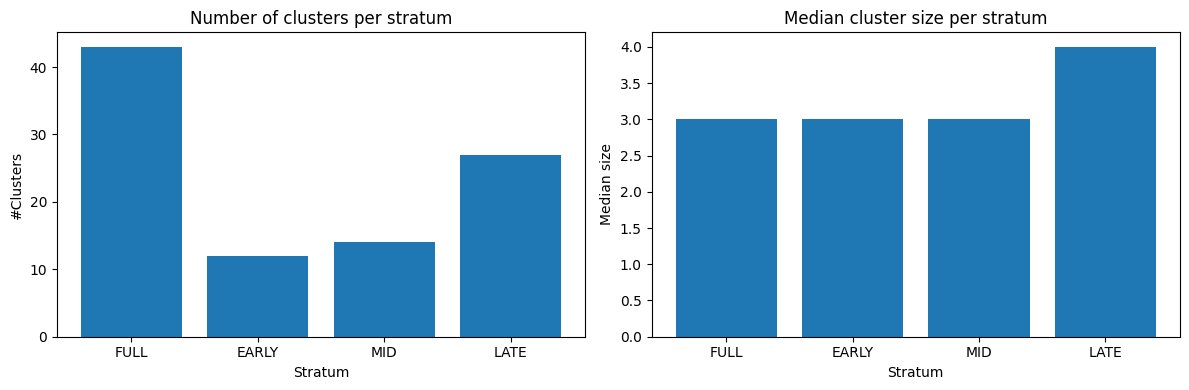

In [11]:
# ==============================================================
# Sequence Clustering with Progress Stratification (fair version)
# - Assumes you already ran Step 1 and have:
#     - `player2ids` : Dict[str, List[int]]  (player -> sequence of int IDs)
#     - `encoder`    : AchvEncoder with `id2achv` mapping id -> token
# - This script:
#     1) Splits players into groups by progress (sequence length)
#        * FULL: length == N_ACH (all achievements)
#        * EARLY : 3–10
#        * MID   : 11–25
#        * LATE  : 26–(N_ACH-1)
#     2) Runs hierarchical clustering within each group using
#        normalized Levenshtein (edit distance / max length)
#     3) Finds a medoid (center player) per cluster
#     4) Prints cluster summaries and a compact category profile
# ==============================================================

import math
from collections import Counter, defaultdict
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
import Levenshtein

# -----------------------------
# Safety checks
# -----------------------------
assert 'player2ids' in globals(), "player2ids not found. Please run Step 1 to build sequences."
assert 'encoder' in globals(), "encoder not found. Please run Step 1 to build sequences."

N_ACH = len(encoder.id2achv)
players_all = list(player2ids.keys())

# -----------------------------
# Achievement → category mapping
# (adjust if you have a different taxonomy)
# -----------------------------
combat_achvs = {"bleedout","zombies10","zombies100","zombies500","zombies2500","kills44mag"}
explore_achvs = {"travel10","travel50","travel250","travel1000","height255","height0","subzeronaked"}
craft_achvs   = {"stoneaxe","bedroll","woodframe","landclaim",
                 "items50","items500","items1500","items5000"}

def get_category(token: str) -> str:
    if token in combat_achvs:
        return "combat"
    if token in explore_achvs:
        return "explore"
    if token in craft_achvs:
        return "craft"
    return "other"

# -----------------------------
# Progress strata
# -----------------------------
def assign_progress_bucket(seq_len: int) -> str:
    if seq_len >= N_ACH:
        return "FULL"
    if 3 <= seq_len <= 10:
        return "EARLY"
    if 11 <= seq_len <= 25:
        return "MID"
    if 26 <= seq_len <= (N_ACH - 1):
        return "LATE"
    return "DROP"  # length < 3 (should already be filtered out earlier)

# Build strata
strata: Dict[str, List[str]] = {"FULL": [], "EARLY": [], "MID": [], "LATE": []}
for pid, seq in player2ids.items():
    bucket = assign_progress_bucket(len(seq))
    if bucket in strata:
        strata[bucket].append(pid)

print("=== Progress strata sizes ===")
for k in ["EARLY","MID","LATE","FULL"]:
    print(f"{k}: {len(strata[k])} players")

# -----------------------------
# Distance and clustering utils
# -----------------------------
def norm_lev(seq_i: List[int], seq_j: List[int]) -> float:
    """Normalized Levenshtein distance in [0,1] using max length."""
    if len(seq_i) == 0 and len(seq_j) == 0:
        return 0.0
    d = Levenshtein.distance(seq_i, seq_j)
    return d / max(len(seq_i), len(seq_j))

def pairwise_distance_matrix(pids: List[str], p2ids: Dict[str, List[int]]) -> np.ndarray:
    n = len(pids)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        si = p2ids[pids[i]]
        for j in range(i+1, n):
            sj = p2ids[pids[j]]
            d = norm_lev(si, sj)
            D[i, j] = d
            D[j, i] = d
    return D

def cluster_with_threshold(D: np.ndarray, method: str = "average", threshold: float = 0.80) -> np.ndarray:
    """Hierarchical clustering on a full distance matrix with a distance cut."""
    if D.shape[0] < 2:
        return np.ones((D.shape[0],), dtype=int)
    condensed = squareform(D)
    Z = linkage(condensed, method=method)
    labels = fcluster(Z, t=threshold, criterion="distance")
    return labels

def find_medoid(pids: List[str], p2ids: Dict[str, List[int]]) -> Tuple[str, float]:
    """Return (center_player_id, avg_intra_distance)."""
    if len(pids) == 1:
        return pids[0], 0.0
    # Compute pairwise once for efficiency
    D = pairwise_distance_matrix(pids, p2ids)
    avg_dist = D.sum(axis=1) / (len(pids) - 1)
    idx = int(np.argmin(avg_dist))
    return pids[idx], float(avg_dist[idx])

def summarize_cluster(pid_center: str, p2ids: Dict[str, List[int]], enc) -> Dict:
    seq_ids = p2ids[pid_center]
    tokens = [enc.id2achv[i] for i in seq_ids]
    cats = [get_category(t) for t in tokens]
    c = Counter(cats)
    ratios = {k: round(v / len(tokens), 2) for k, v in c.items()} if tokens else {}
    return {
        "center_player": pid_center,
        "length": len(tokens),
        "tokens": tokens,
        "category_ratios": ratios
    }

# -----------------------------
# Run clustering per stratum
# -----------------------------
CUT = 0.80      # distance cut per stratum (you can tweak per group if needed)
LINK = "average"

results = {}    # stratum -> DataFrame with cluster summaries
label_maps = {} # stratum -> DataFrame with player -> cluster label

for stratum, pids in strata.items():
    print(f"\n=== Clustering stratum: {stratum} (n={len(pids)}) ===")
    if len(pids) == 0:
        print("No players in this stratum; skipping.")
        continue
    if len(pids) == 1:
        labels = np.array([1], dtype=int)
    else:
        D = pairwise_distance_matrix(pids, player2ids)
        labels = cluster_with_threshold(D, method=LINK, threshold=CUT)

    lab_df = pd.DataFrame({"player_id": pids, "cluster": labels})
    label_maps[stratum] = lab_df

    # Summaries per cluster
    cluster_rows = []
    for cid, sub in lab_df.groupby("cluster"):
        members = sub["player_id"].tolist()
        center_pid, avg_intra = find_medoid(members, player2ids)
        summary = summarize_cluster(center_pid, player2ids, encoder)
        row = {
            "stratum": stratum,
            "cluster": int(cid),
            "size": len(members),
            "center_player": summary["center_player"],
            "center_len": summary["length"],
            "avg_intra_dist": round(avg_intra, 3),
            "category_ratios": summary["category_ratios"],
            "center_tokens": summary["tokens"],
        }
        cluster_rows.append(row)

    df_summary = pd.DataFrame(cluster_rows).sort_values(["size"], ascending=False)
    results[stratum] = df_summary

    print(f"Clusters: {df_summary.shape[0]}")
    print("Top 5 clusters by size:")
    disp_cols = ["stratum","cluster","size","center_player","center_len","avg_intra_dist","category_ratios"]
    print(df_summary[disp_cols].head(5).to_string(index=False))

# -----------------------------
# (Optional) Combine summaries
# -----------------------------
all_summaries = pd.concat(results.values(), ignore_index=True) if results else pd.DataFrame()
print("\n=== Combined top clusters across strata (by size) ===")
if not all_summaries.empty:
    print(all_summaries.sort_values("size", ascending=False)
                      .head(10)[["stratum","cluster","size","center_len","avg_intra_dist","category_ratios"]]
                      .to_string(index=False))
else:
    print("No summaries produced.")

# -----------------------------
# (Optional) Minimal visualization:
# number of clusters and sizes per stratum
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) number of clusters per stratum
names = []
ncls = []
for s, df_s in results.items():
    names.append(s)
    ncls.append(df_s.shape[0])
axes[0].bar(names, ncls)
axes[0].set_title("Number of clusters per stratum")
axes[0].set_xlabel("Stratum")
axes[0].set_ylabel("#Clusters")

# 2) median cluster size per stratum
med_sizes = []
for s, df_s in results.items():
    med_sizes.append(int(df_s["size"].median()) if not df_s.empty else 0)
axes[1].bar(names, med_sizes)
axes[1].set_title("Median cluster size per stratum")
axes[1].set_xlabel("Stratum")
axes[1].set_ylabel("Median size")

plt.tight_layout()
plt.show()


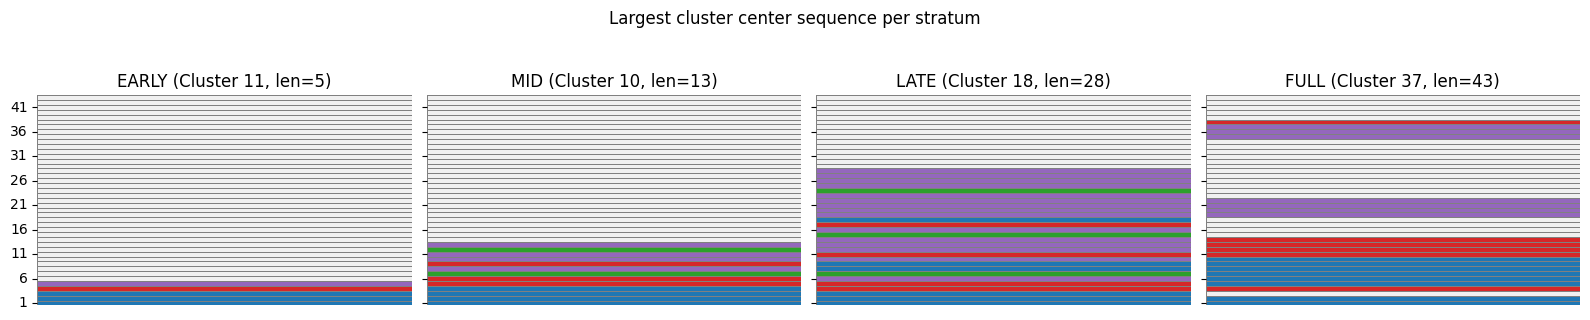

In [12]:
# =========================================================
# Heatmaps for largest cluster in each stratum
# =========================================================
import seaborn as sns

# category → color mapping
palette = {
    "craft": "#1f77b4",   # blue
    "combat": "#d62728",  # red
    "explore": "#2ca02c", # green
    "other": "#9467bd",   # purple
    None: "#f0f0f0"       # grey for padding
}

def plot_stratum_heatmaps(results_dict, encoder, player2ids, max_len=None):
    strata_order = ["EARLY", "MID", "LATE", "FULL"]
    n_strata = len(strata_order)
    fig, axes = plt.subplots(1, n_strata, figsize=(4*n_strata, 3), sharey=True)

    for idx, stratum in enumerate(strata_order):
        ax = axes[idx]
        if stratum not in results_dict or results_dict[stratum].empty:
            ax.axis('off')
            continue

        # largest cluster in this stratum
        df_s = results_dict[stratum]
        cid = df_s.iloc[0]["cluster"]  # already sorted by size
        center_tokens = df_s.iloc[0]["center_tokens"]
        cats = [get_category(t) for t in center_tokens]

        # pad if needed to match max_len
        if max_len is None:
            max_len = max(len(center_tokens) for s in strata_order if s in results_dict and not results_dict[s].empty
                          for center_tokens in [results_dict[s].iloc[0]["center_tokens"]])
        padded = cats + [None] * (max_len - len(cats))

        # convert to numeric for seaborn
        cat_list = list(palette.keys())
        cat_to_num = {c: i for i, c in enumerate(cat_list)}
        num_seq = [[cat_to_num[c]] for c in padded]  # vertical arrangement

        # plot heatmap
        cmap = sns.color_palette([palette[c] for c in cat_list])
        sns.heatmap(num_seq, cmap=cmap, cbar=False, ax=ax, linewidths=0.5, linecolor='gray')

        ax.set_title(f"{stratum} (Cluster {cid}, len={len(center_tokens)})")
        ax.set_xticks([])
        ax.set_yticks(np.arange(0.5, max_len, 5))
        ax.set_yticklabels(np.arange(1, max_len+1, 5))
        ax.invert_yaxis()

    plt.suptitle("Largest cluster center sequence per stratum", y=1.05)
    plt.tight_layout()
    plt.show()

# Run the plotting function
plot_stratum_heatmaps(results, encoder, player2ids)


KeyError: 'None'

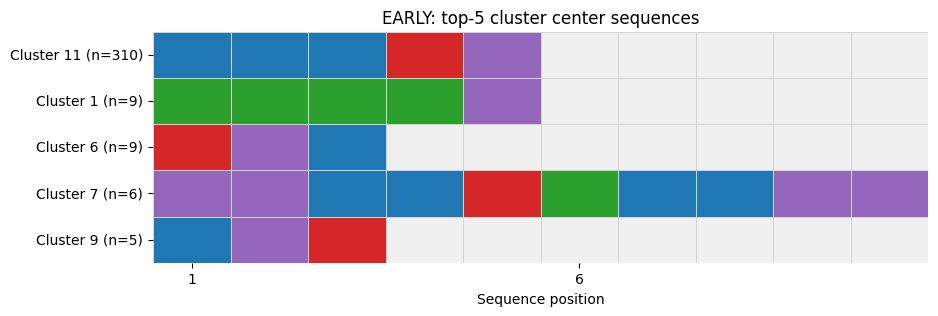

In [13]:
# =========================================================
# Heatmaps: top-K cluster center sequences per STRATUM
# Requires:
#   - results[stratum]: DataFrame with columns ["cluster","size","center_tokens",...]
#   - get_category(token): -> {"craft","combat","explore","other"}
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# category -> color
CAT_COLORS = {
    "craft":   "#1f77b4",  # blue
    "combat":  "#d62728",  # red
    "explore": "#2ca02c",  # green
    "other":   "#9467bd",  # purple
    None:      "#f0f0f0"   # padding
}

def plot_stratum_topK_heatmap(results_dict, top_k=5, strata=("EARLY","MID","LATE","FULL")):
    for stratum in strata:
        if stratum not in results_dict or results_dict[stratum].empty:
            print(f"[{stratum}] no clusters to show.")
            continue

        df_s = results_dict[stratum].sort_values("size", ascending=False).head(top_k).copy()
        if df_s.empty:
            print(f"[{stratum}] empty after top_k filter.")
            continue

        # Build category sequences for each cluster center
        cat_seqs = []
        row_labels = []
        max_len = 0
        for _, row in df_s.iterrows():
            tokens = row["center_tokens"]
            cats = [get_category(t) for t in tokens]
            cat_seqs.append(cats)
            row_labels.append(f"Cluster {row['cluster']} (n={row['size']})")
            max_len = max(max_len, len(cats))

        # Pad to the same length
        cat_to_num = {c:i for i,c in enumerate(CAT_COLORS.keys())}
        mat = []
        for cats in cat_seqs:
            padded = cats + [None]*(max_len - len(cats))
            mat.append([cat_to_num[c] for c in padded])
        mat = np.array(mat)

        # Plot
        plt.figure(figsize=(max(10, max_len*0.35), max(2.5, top_k*0.6)))
        cmap = sns.color_palette([CAT_COLORS[c] for c in CAT_COLORS.keys()])
        sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="lightgray")

        # Axes cosmetics
        plt.yticks(np.arange(0.5, len(row_labels)+0.5, 1), row_labels, rotation=0)
        xticks = np.arange(0.5, max_len+0.5, 5)
        plt.xticks(xticks, np.arange(1, max_len+1, 5))
        plt.xlabel("Sequence position")
        plt.title(f"{stratum}: top-{top_k} cluster center sequences")

        # Legend
        from matplotlib.patches import Patch
        handles = [Patch(facecolor=CAT_COLORS[k], label=str(k)) for k in ["craft","combat","explore","other","None"]]
        plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
        plt.tight_layout()
        plt.show()

# Run: one heatmap per stratum, top-5 clusters by size
plot_stratum_topK_heatmap(results, top_k=5)
